In [ ]:
#Importing bunch of libraries
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
import matplotlib.pyplot as plt
import re
import time
import warnings
import numpy as np
from nltk.corpus import stopwords
from sklearn.decomposition import TruncatedSVD
from sklearn.feature_extraction.text import CountVectorizer
import seaborn as sns
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import confusion_matrix
from sklearn.metrics.classification import accuracy_score, log_loss
from sklearn.linear_model import SGDClassifier
from scipy.sparse import hstack
from sklearn.svm import SVC
from sklearn.model_selection import StratifiedKFold 
from collections import Counter, defaultdict
from sklearn.calibration import CalibratedClassifierCV
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
import math
from sklearn.ensemble import RandomForestClassifier
from sklearn import model_selection
from sklearn.linear_model import LogisticRegression
warnings.filterwarnings("ignore")

/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:144: FutureWarning: The sklearn.metrics.classification module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.metrics. Anything that cannot be imported from sklearn.metrics is now part of the private API.
  warnings.warn(message, FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/externals/six.py:31: FutureWarning: The module is deprecated in version 0.21 and will be removed in version 0.23 since we've dropped support for Python 2.7. Please rely on the official version of six (https://pypi.org/project/six/).
  "(https://pypi.org/project/six/).", FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:144: FutureWarning: The sklearn.neighbors.base module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported f

# Problem Statement


Source: Challenge Page(HackerEarth.com)

**We need to predict if the server will be hacked**

Evaluation Criteria:  score = recall_score(actual_values, predicted_values)

**Detail Problem statement:** All the countries across the globe have adapted to means of digital payments. And with the increased volume of digital payments, hacking has become a pretty common event. We have data with some anonymized variables. We need to build a predictive model which can identify a pattern in these variables and suggest that a hack is going to happen so that the cyber security can somehow stop it before it actually happens.

# Exploratory Data Analysis

<h1> Loading train Data-Set </h1>

In [ ]:
train_data = pd.read_csv('/content/drive/My Drive/Novartis_Test/Train.csv')

In [ ]:
# Let us see what we have here.....
train_data.head()

,INCIDENT_ID,DATE,X_1,X_2,X_3,X_4,X_5,X_6,X_7,X_8,X_9,X_10,X_11,X_12,X_13,X_14,X_15,MULTIPLE_OFFENSE
0,CR_102659,04-JUL-04,0,36,34,2,1,5,6,1,6,1,174,1.0,92,29,36,0
1,CR_189752,18-JUL-17,1,37,37,0,0,11,17,1,6,1,236,1.0,103,142,34,1
2,CR_184637,15-MAR-17,0,3,2,3,5,1,0,2,3,1,174,1.0,110,93,34,1
3,CR_139071,13-FEB-09,0,33,32,2,1,7,1,1,6,1,249,1.0,72,29,34,1
4,CR_109335,13-APR-05,0,33,32,2,1,8,3,0,5,1,174,0.0,112,29,43,1


INCIDENT ID: Unique identifier for an incident

DATE: Date of the incident

X_1 - X_15: Anonymized Logging Parameter

MULTIPLE_OFFENSE: Indicates if incident was a hack or not

In [ ]:
print('Total number of data point in train are: {} and total columns: {}'.format(train_data.shape[0], train_data.shape[1]))

Total number of data point in train are: 23856 and total columns: 18


**Let us first look at a simple info about all the data points that we have**

In [ ]:
train_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 23856 entries, 0 to 23855
Data columns (total 18 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   INCIDENT_ID       23856 non-null  object 
 1   DATE              23856 non-null  object 
 2   X_1               23856 non-null  int64  
 3   X_2               23856 non-null  int64  
 4   X_3               23856 non-null  int64  
 5   X_4               23856 non-null  int64  
 6   X_5               23856 non-null  int64  
 7   X_6               23856 non-null  int64  
 8   X_7               23856 non-null  int64  
 9   X_8               23856 non-null  int64  
 10  X_9               23856 non-null  int64  
 11  X_10              23856 non-null  int64  
 12  X_11              23856 non-null  int64  
 13  X_12              23674 non-null  float64
 14  X_13              23856 non-null  int64  
 15  X_14              23856 non-null  int64  
 16  X_15              23856 non-null  int64 

We do have missing values, X_12 have some missing values.....

In [ ]:
print('Number of missing data points in data is: {}'.format(train_data[train_data['X_12'].isnull()].shape[0]))

Number of missing data points in data is: 182


In [ ]:
#Checking the total number of unique labels in X_12
train_data['X_12'].nunique() #We will deal with these missing values later....

23

**Let us simply run a describe to get info about logging parameters**

In [ ]:
train_data[train_data.columns[2:-1]].describe()

,X_1,X_2,X_3,X_4,X_5,X_6,X_7,X_8,X_9,X_10,X_11,X_12,X_13,X_14,X_15
count,23856.000000,23856.000000,23856.000000,23856.000000,23856.000000,23856.000000,23856.000000,23856.000000,23856.000000,23856.000000,23856.000000,23674.000000,23856.000000,23856.000000,23856.000000
mean,0.483778,24.791206,24.637450,4.276744,2.455609,6.154175,4.876509,0.972460,4.924128,1.244802,206.954519,0.974064,85.237383,72.674296,33.464747
std,1.439738,15.240231,15.135093,2.944672,1.963095,4.471756,3.881931,1.453144,1.362625,1.119301,93.033348,1.167725,27.597226,43.297320,8.386834
min,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,7.000000,8.000000,2.000000,1.000000,3.000000,2.000000,0.000000,5.000000,1.000000,174.000000,1.000000,72.000000,29.000000,34.000000
50%,0.000000,24.000000,24.000000,4.000000,3.000000,5.000000,4.000000,1.000000,5.000000,1.000000,249.000000,1.000000,98.000000,62.000000,34.000000
75%,0.000000,36.000000,35.000000,6.000000,5.000000,8.000000,7.000000,1.000000,6.000000,1.000000,249.000000,1.000000,103.000000,107.000000,34.000000
max,7.000000,52.000000,52.000000,10.000000,5.000000,19.000000,18.000000,99.000000,6.000000,90.000000,332.000000,90.000000,116.000000,142.000000,50.000000


The only information we have about these are that they are anonymized logging parameter, we need to understand them before making a decision as what kind of variables are they....

**Let us get some insight about our target variable**

In [ ]:
print(train_data['MULTIPLE_OFFENSE'].value_counts())
print(train_data['MULTIPLE_OFFENSE'].value_counts(normalize = True))

1    22788
0     1068
Name: MULTIPLE_OFFENSE, dtype: int64
1    0.955231
0    0.044769
Name: MULTIPLE_OFFENSE, dtype: float64


So from above output it is evident that we have a highly imbalanced dataset, with points belonging to class 1 covering 95% of the data.

In [ ]:
print("Number of unique values for feature:")
train_data.nunique()

Number of unique values for feature:


INCIDENT_ID         23856
DATE                 9121
X_1                     8
X_2                    52
X_3                    52
X_4                    10
X_5                     5
X_6                    19
X_7                    19
X_8                    24
X_9                     7
X_10                   24
X_11                  133
X_12                   23
X_13                   60
X_14                   62
X_15                   28
MULTIPLE_OFFENSE        2
dtype: int64

We see a same number of unique value for few of our features...
Let us see a relation between these features....

In [ ]:
#Ref: https://stackoverflow.com/questions/12860421/python-pandas-pivot-table-with-aggfunc-count-unique-distinct
#Using the below code, we are trying to see the relationship b/w various features
rel = {i : train_data[train_data.columns[2:-1]].pivot_table(index = i, aggfunc = lambda x:len(x.unique())).apply(np.max) for i in train_data.columns[2:-1]}

In [ ]:
rel = pd.DataFrame(rel)

In [ ]:
rel

,X_1,X_2,X_3,X_4,X_5,X_6,X_7,X_8,X_9,X_10,X_11,X_12,X_13,X_14,X_15
X_1,NaN,6.0,6.0,8.0,8.0,6.0,6.0,8.0,8.0,8.0,8.0,8.0,8.0,8.0,8.0
X_10,18.0,13.0,13.0,18.0,19.0,12.0,12.0,16.0,18.0,NaN,16.0,10.0,18.0,17.0,22.0
X_11,117.0,49.0,49.0,70.0,84.0,56.0,56.0,105.0,93.0,75.0,NaN,89.0,84.0,78.0,105.0
X_12,19.0,15.0,15.0,18.0,19.0,13.0,13.0,18.0,20.0,6.0,17.0,NaN,17.0,19.0,22.0
X_13,56.0,40.0,40.0,44.0,48.0,39.0,39.0,50.0,50.0,44.0,37.0,48.0,NaN,47.0,56.0
X_14,56.0,33.0,33.0,39.0,48.0,35.0,35.0,49.0,48.0,46.0,38.0,47.0,41.0,NaN,56.0
X_15,23.0,16.0,16.0,18.0,20.0,18.0,18.0,21.0,21.0,21.0,22.0,21.0,16.0,19.0,NaN
X_2,51.0,NaN,1.0,9.0,17.0,49.0,49.0,52.0,52.0,52.0,52.0,52.0,51.0,51.0,52.0
X_3,51.0,1.0,NaN,9.0,17.0,49.0,49.0,52.0,52.0,52.0,52.0,52.0,51.0,51.0,52.0
X_4,9.0,1.0,1.0,NaN,3.0,10.0,10.0,10.0,10.0,10.0,10.0,10.0,10.0,10.0,10.0


1. We can see 1-1 relationship between X_2-X_3 and X_6-X_7
2. From any other feature to both of these pairs, there is a 1 to many relationship with same number of unique values.
3. We can conclude that for every value to X_2 there is a distinct value in X_3, or in other words they are equivalent,i.e, X_2 = X_3, same goes with the other pair, so we can use any one of the feature from each of the pair during modelling.

Note: X_10 and X_12 also shows high equivalence, but we are keeping them for now.....

In [ ]:
train_data= train_data.drop(['X_3', 'X_6'], axis = 1)

As for 24k(roughly) data points, the max we have is 133 unique values, we can assume that our that our data points are categorical(X_1 to X_15)

In [ ]:
train_data.nunique()

INCIDENT_ID         23856
DATE                 9121
X_1                     8
X_2                    52
X_4                    10
X_5                     5
X_7                    19
X_8                    24
X_9                     7
X_10                   24
X_11                  133
X_12                   23
X_13                   60
X_14                   62
X_15                   28
MULTIPLE_OFFENSE        2
dtype: int64

In [ ]:
train_data.head()

,INCIDENT_ID,DATE,X_1,X_2,X_4,X_5,X_7,X_8,X_9,X_10,X_11,X_12,X_13,X_14,X_15,MULTIPLE_OFFENSE
0,CR_102659,04-JUL-04,0,36,2,1,6,1,6,1,174,1.0,92,29,36,0
1,CR_189752,18-JUL-17,1,37,0,0,17,1,6,1,236,1.0,103,142,34,1
2,CR_184637,15-MAR-17,0,3,3,5,0,2,3,1,174,1.0,110,93,34,1
3,CR_139071,13-FEB-09,0,33,2,1,1,1,6,1,249,1.0,72,29,34,1
4,CR_109335,13-APR-05,0,33,2,1,3,0,5,1,174,0.0,112,29,43,1


**Let us start our analysis with the Date field**

In [ ]:
date_analysis_df = train_data[['DATE', 'MULTIPLE_OFFENSE']]

In [ ]:
date_analysis_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 23856 entries, 0 to 23855
Data columns (total 2 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   DATE              23856 non-null  object
 1   MULTIPLE_OFFENSE  23856 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 372.9+ KB


In [ ]:
#Converting our column to datetime....
date_analysis_df['DATE'] = pd.to_datetime(date_analysis_df['DATE'])

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


Let us create columns, containing year, month, day, day_of_week, is_weekend.....
We need to understand what our task is, basically we need to predict if hack is going to happen, in terms of what is given to us is just date, from which we won't be getting much info, but we can still see if we get any pattern or any info out of it. If along with date we would have given time stamp as well, it may be of more use to it, as we could have identified some pattern out of it, as to at what time generally some event occur and could have used that as a feature to our model.

In [ ]:
#Let us add some new columns, month, year and day
date_analysis_df['year'] = date_analysis_df['DATE'].dt.year
date_analysis_df['month'] = date_analysis_df['DATE'].dt.month
date_analysis_df['day'] = date_analysis_df['DATE'].dt.day

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

In [ ]:
#adding 2 more columns, dow and is_weekend
date_analysis_df['dow'] = date_analysis_df['DATE'].apply(lambda x: x.date().weekday())

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [ ]:
date_analysis_df.nunique()

DATE                9121
MULTIPLE_OFFENSE       2
year                  28
month                 12
day                   31
dow                    7
dtype: int64

In [ ]:
print('We have data from {} till {}'.format(date_analysis_df['year'].min(), date_analysis_df['year'].max()))

We have data from 1991 till 2018


We have 28 years of data.....

Let's plot for each class label separately and see if we can find some information from this, plotting year doesn't make much sense, but let's see....

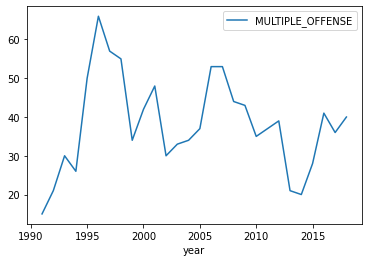

In [ ]:
date_analysis_df[['year', 'MULTIPLE_OFFENSE']][date_analysis_df['MULTIPLE_OFFENSE'] == 0].groupby('year').count().plot()

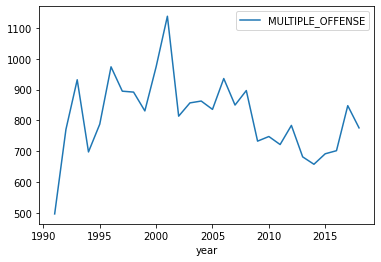

In [ ]:
date_analysis_df[['year', 'MULTIPLE_OFFENSE']][date_analysis_df['MULTIPLE_OFFENSE'] == 1].groupby('year').count().plot()

Year patterns are almost the same for both our class labels, there are some patterns, but they won't add much info to our models and will only work as a noise if we add them as features....

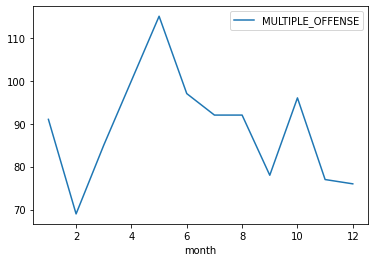

In [ ]:
date_analysis_df[['month', 'MULTIPLE_OFFENSE']][date_analysis_df['MULTIPLE_OFFENSE'] == 0].groupby('month').count().plot()

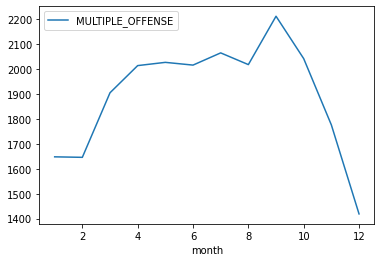

In [ ]:
date_analysis_df[['month', 'MULTIPLE_OFFENSE']][date_analysis_df['MULTIPLE_OFFENSE'] == 1].groupby('month').count().plot()

We see some drop for both the class labels, end of month, but this is due to the less number of reported incident during this quater...

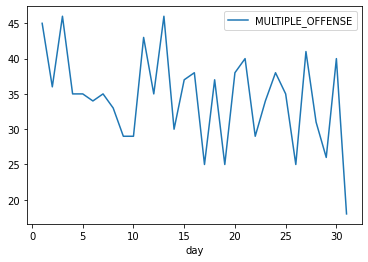

In [ ]:
date_analysis_df[['day', 'MULTIPLE_OFFENSE']][date_analysis_df['MULTIPLE_OFFENSE'] == 0].groupby('day').count().plot()

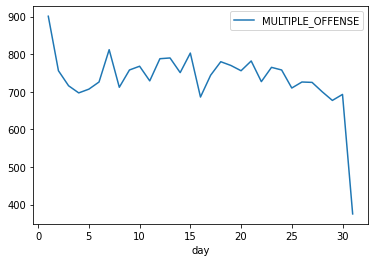

In [ ]:
date_analysis_df[['day', 'MULTIPLE_OFFENSE']][date_analysis_df['MULTIPLE_OFFENSE'] == 1].groupby('day').count().plot()

This is having a normal signal for both the labels and hence this can be ignored, we do see a drop in the end for both the plots(not every month have 31 days)

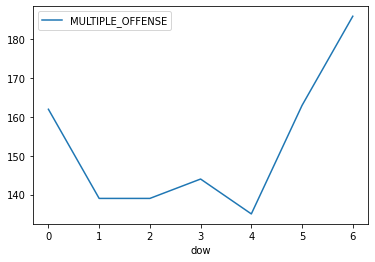

In [ ]:
date_analysis_df[['dow', 'MULTIPLE_OFFENSE']][date_analysis_df['MULTIPLE_OFFENSE'] == 0].groupby('dow').count().plot()

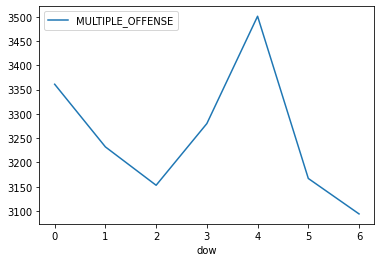

In [ ]:
date_analysis_df[['dow', 'MULTIPLE_OFFENSE']][date_analysis_df['MULTIPLE_OFFENSE'] == 1].groupby('dow').count().plot()

Positive cases are slighly lesser on weekend as compared to weekdays, also, negative cases are slightly more on weekends as compared to weekdays...
Let us add a binary feature, which is 1 if it is a weekend 0 otherwise...

In [ ]:
date_analysis_df['is_weekend'] = date_analysis_df['DATE'].apply(lambda x: 1 if x.date().weekday() in (5, 6) else 0)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [ ]:
date_analysis_df[date_analysis_df['MULTIPLE_OFFENSE'] == 0]['is_weekend'].value_counts(normalize = True)

0    0.673221
1    0.326779
Name: is_weekend, dtype: float64

In [ ]:
date_analysis_df[date_analysis_df['MULTIPLE_OFFENSE'] == 1]['is_weekend'].value_counts(normalize = True)

0    0.72525
1    0.27475
Name: is_weekend, dtype: float64

This feature can make some difference when combined with dow, hence, adding 2 new features to our train_data, dow and is_weekend

In [ ]:
train_data['DATE'] = pd.to_datetime(train_data['DATE'])
train_data['dow'] = train_data['DATE'].apply(lambda x: x.date().weekday())
train_data['is_weekend'] = train_data['DATE'].apply(lambda x: 1 if x.date().weekday() in (5, 6) else 0)

In [ ]:
#Dropping DATE column
train_data = train_data.drop('DATE', axis = 1)

In [ ]:
train_data.head()

,INCIDENT_ID,X_1,X_2,X_4,X_5,X_7,X_8,X_9,X_10,X_11,X_12,X_13,X_14,X_15,MULTIPLE_OFFENSE,dow,is_weekend
0,CR_102659,0,36,2,1,6,1,6,1,174,1.0,92,29,36,0,6,1
1,CR_189752,1,37,0,0,17,1,6,1,236,1.0,103,142,34,1,1,0
2,CR_184637,0,3,3,5,0,2,3,1,174,1.0,110,93,34,1,2,0
3,CR_139071,0,33,2,1,1,1,6,1,249,1.0,72,29,34,1,4,0
4,CR_109335,0,33,2,1,3,0,5,1,174,0.0,112,29,43,1,2,0


We are done with date column, now let's move on to our other features from X_1 to X_15, usually when we deal with categorical data, knowing what the column itself gives a lot of info about the variable and also helps us in understanding what can be done, but in this case, we don't have that info and we need to see using the given amount if we can come up with some info or even relation among the variables...

In [ ]:
train_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 23856 entries, 0 to 23855
Data columns (total 17 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   INCIDENT_ID       23856 non-null  object 
 1   X_1               23856 non-null  int64  
 2   X_2               23856 non-null  int64  
 3   X_4               23856 non-null  int64  
 4   X_5               23856 non-null  int64  
 5   X_7               23856 non-null  int64  
 6   X_8               23856 non-null  int64  
 7   X_9               23856 non-null  int64  
 8   X_10              23856 non-null  int64  
 9   X_11              23856 non-null  int64  
 10  X_12              23674 non-null  float64
 11  X_13              23856 non-null  int64  
 12  X_14              23856 non-null  int64  
 13  X_15              23856 non-null  int64  
 14  MULTIPLE_OFFENSE  23856 non-null  int64  
 15  dow               23856 non-null  int64  
 16  is_weekend        23856 non-null  int64 

X_12 have missing values, let us see, how we plan to deal with it first, and then we will move ahead with the EDA part.....

Two ways in which we can fill these are:
1. Simply remove these missing rows.
2. Use clustering to create clusters and then identify which cluster those missing points belong to and assign them the value based on that.

Let us first see the class labels for these missing rows....

In [ ]:
train_data[train_data['X_12'].isnull()]['MULTIPLE_OFFENSE'].unique()

array([1])

Ok, so all these rows belong to label 1, and we have 182 missing data points, also, this is our majority class, with 95% of the data points, hence removing these rows from the data set.....

In [ ]:
train_data = train_data.dropna()

Since we have dealt with the missing values, let us explore our logging features

Converting all our features to type object....

In [ ]:
train_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 23674 entries, 0 to 23855
Data columns (total 17 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   INCIDENT_ID       23674 non-null  object 
 1   X_1               23674 non-null  int64  
 2   X_2               23674 non-null  int64  
 3   X_4               23674 non-null  int64  
 4   X_5               23674 non-null  int64  
 5   X_7               23674 non-null  int64  
 6   X_8               23674 non-null  int64  
 7   X_9               23674 non-null  int64  
 8   X_10              23674 non-null  int64  
 9   X_11              23674 non-null  int64  
 10  X_12              23674 non-null  float64
 11  X_13              23674 non-null  int64  
 12  X_14              23674 non-null  int64  
 13  X_15              23674 non-null  int64  
 14  MULTIPLE_OFFENSE  23674 non-null  int64  
 15  dow               23674 non-null  object 
 16  is_weekend        23674 non-null  int64 

In [ ]:
train_data['X_1'] = train_data['X_1'].astype('str')
train_data['X_2'] = train_data['X_2'].astype('str')
train_data['X_4'] = train_data['X_4'].astype('str')
train_data['X_5'] = train_data['X_5'].astype('str')
train_data['X_7'] = train_data['X_7'].astype('str')
train_data['X_8'] = train_data['X_8'].astype('str')
train_data['X_9'] = train_data['X_9'].astype('str')
train_data['X_10'] = train_data['X_10'].astype('str')
train_data['X_11'] = train_data['X_11'].astype('str')
train_data['X_12'] = train_data['X_12'].astype('str')
train_data['X_13'] = train_data['X_13'].astype('str')
train_data['X_14'] = train_data['X_14'].astype('str')
train_data['X_15'] = train_data['X_15'].astype('str')
train_data['dow'] = train_data['dow'].astype('str')

In [ ]:
train_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 23674 entries, 0 to 23855
Data columns (total 17 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   INCIDENT_ID       23674 non-null  object
 1   X_1               23674 non-null  object
 2   X_2               23674 non-null  object
 3   X_4               23674 non-null  object
 4   X_5               23674 non-null  object
 5   X_7               23674 non-null  object
 6   X_8               23674 non-null  object
 7   X_9               23674 non-null  object
 8   X_10              23674 non-null  object
 9   X_11              23674 non-null  object
 10  X_12              23674 non-null  object
 11  X_13              23674 non-null  object
 12  X_14              23674 non-null  object
 13  X_15              23674 non-null  object
 14  MULTIPLE_OFFENSE  23674 non-null  int64 
 15  dow               23674 non-null  object
 16  is_weekend        23674 non-null  int64 
dtypes: int64(2),

In [ ]:
train_data = train_data.drop('INCIDENT_ID', axis = 1)

In [ ]:
train_data.columns

Index(['X_1', 'X_2', 'X_4', 'X_5', 'X_7', 'X_8', 'X_9', 'X_10', 'X_11', 'X_12',
       'X_13', 'X_14', 'X_15', 'MULTIPLE_OFFENSE', 'dow', 'is_weekend'],
      dtype='object')

<h1> Posing our problem into a ML problem </h1>

<h2> Test, Train and cv split </h2>

In [ ]:
from sklearn.model_selection import train_test_split
y_true = train_data['MULTIPLE_OFFENSE'].values
X_train, test_df, y_train, y_test = train_test_split(train_data, y_true, stratify=y_true, test_size=0.2)
train_df, cv_df, y_train, y_cv = train_test_split(X_train, y_train, stratify=y_train, test_size=0.2)

In [ ]:
print('Number of data points in train data:', train_df.shape[0])
print('Number of data points in test data:', test_df.shape[0])
print('Number of data points in cross validation data:', cv_df.shape[0])

Number of data points in train data: 15151
Number of data points in test data: 4735
Number of data points in cross validation data: 3788


Since we have done a split, let us just check the distribution of Y_i's in train, test and cv

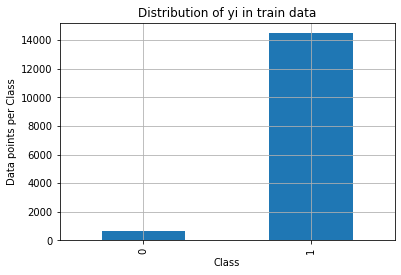

Number of data points in class 0 : 683 (4.508 %)
Number of data points in class 1 : 14468 (95.492 %)
--------------------------------------------------------------------------------


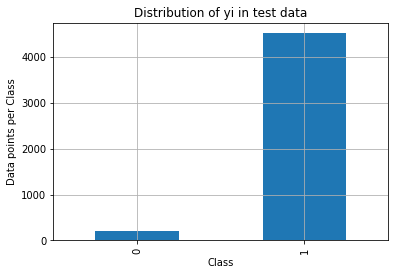

Number of data points in class 0 : 214 (4.52 %)
Number of data points in class 1 : 4521 (95.48 %)
--------------------------------------------------------------------------------


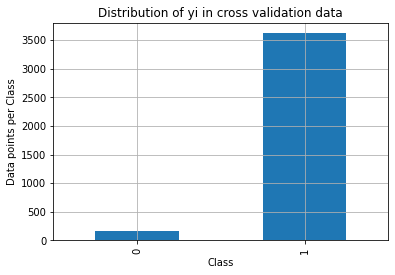

Number of data points in class 0 : 171 (4.514 %)
Number of data points in class 1 : 3617 (95.486 %)


In [ ]:
train_class_distribution = train_df['MULTIPLE_OFFENSE'].value_counts().sort_index()
test_class_distribution = test_df['MULTIPLE_OFFENSE'].value_counts().sort_index()
cv_class_distribution = cv_df['MULTIPLE_OFFENSE'].value_counts().sort_index()

train_class_distribution.plot(kind='bar')
plt.xlabel('Class')
plt.ylabel('Data points per Class')
plt.title('Distribution of yi in train data')
plt.grid()
plt.show()

for i in range(train_class_distribution.shape[0]):
  print('Number of data points in class {} : {} ({} %)'.format(i, train_class_distribution.values[i], np.round((train_class_distribution.values[i]/train_df.shape[0]*100), 3)))

print('-'*80)
test_class_distribution.plot(kind='bar')
plt.xlabel('Class')
plt.ylabel('Data points per Class')
plt.title('Distribution of yi in test data')
plt.grid()
plt.show()

for i in range(test_class_distribution.shape[0]):
  print('Number of data points in class {} : {} ({} %)'.format(i, test_class_distribution.values[i], np.round((test_class_distribution.values[i]/test_df.shape[0]*100), 3)))


print('-'*80)
cv_class_distribution.plot(kind='bar')
plt.xlabel('Class')
plt.ylabel('Data points per Class')
plt.title('Distribution of yi in cross validation data')
plt.grid()
plt.show()

for i in range(cv_class_distribution.shape[0]):
  print('Number of data points in class {} : {} ({} %)'.format(i, cv_class_distribution.values[i], np.round((cv_class_distribution.values[i]/cv_df.shape[0]*100), 3)))

<h2> Univariate Analysis </h2>

Since we have split the data , let us do a simple univariate analysis on all our categorical features.....

In [ ]:
def feature_analysis(feature):
  unique = train_df[feature].value_counts()
  print('Number of Unique values for feature {} is: {}'.format(feature, unique.shape[0]))
  print(unique.head(10))
  print('\nThere are {} different categories of {} in train data, and they are distibuted as follows'.format(unique.shape[0], feature))

  print('\n\nLet us check the distribution of these unique features....')
  s = sum(unique.values)
  h = unique.values/s
  plt.plot(h, label="Histrogram of Genes")
  plt.xlabel('Index of {}'.format(feature))
  plt.ylabel('Number of Occurances')
  plt.legend()
  plt.grid()
  plt.show()

  print('\n\n')
  c = np.cumsum(h)
  plt.plot(c,label='Cumulative distribution of {}'.format(feature))
  plt.grid()
  plt.legend()
  plt.show()

Number of Unique values for feature X_1 is: 8
0    12062
1     2250
7      550
5      180
3       85
4       16
2        5
6        3
Name: X_1, dtype: int64

There are 8 different categories of X_1 in train data, and they are distibuted as follows


Let us check the distribution of these unique features....


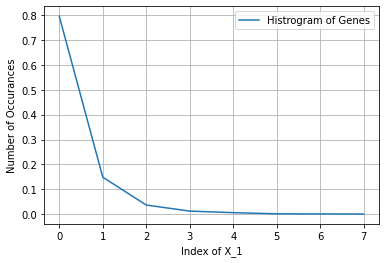

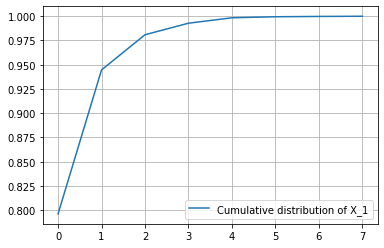

In [ ]:
feature_analysis('X_1')

Number of Unique values for feature X_2 is: 52
4     2546
36    1386
33    1379
24     827
21     812
37     618
49     615
45     586
3      481
22     428
Name: X_2, dtype: int64

There are 52 different categories of X_2 in train data, and they are distibuted as follows


Let us check the distribution of these unique features....


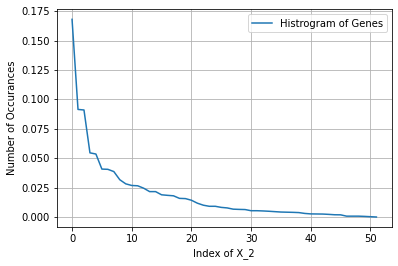

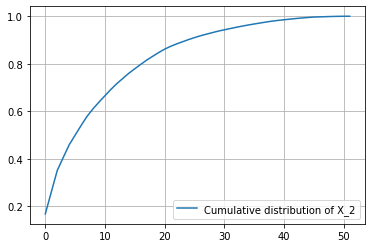

In [ ]:
feature_analysis('X_2')

Number of Unique values for feature X_4 is: 10
6     3506
2     3006
0     2103
7     1832
4     1312
3     1187
9      872
10     796
1      536
5        1
Name: X_4, dtype: int64

There are 10 different categories of X_4 in train data, and they are distibuted as follows


Let us check the distribution of these unique features....


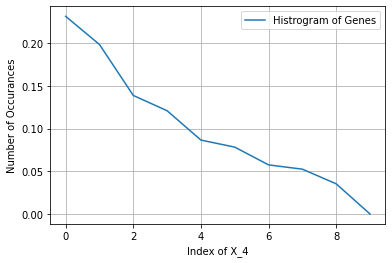

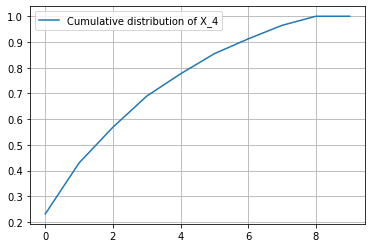

In [ ]:
feature_analysis('X_4')

Number of Unique values for feature X_5 is: 5
5    4693
1    4318
3    3164
0    2975
2       1
Name: X_5, dtype: int64

There are 5 different categories of X_5 in train data, and they are distibuted as follows


Let us check the distribution of these unique features....


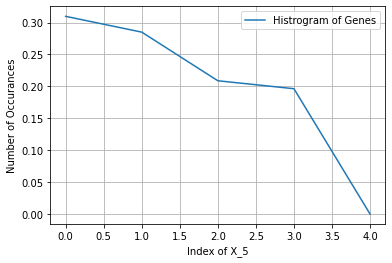

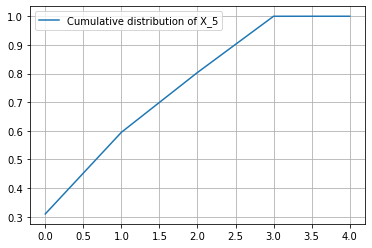

In [ ]:
feature_analysis('X_5')

Number of Unique values for feature X_7 is: 19
0     2176
6     1713
4     1695
10    1490
7     1467
2     1458
1     1437
5     1069
3      896
8      786
Name: X_7, dtype: int64

There are 19 different categories of X_7 in train data, and they are distibuted as follows


Let us check the distribution of these unique features....


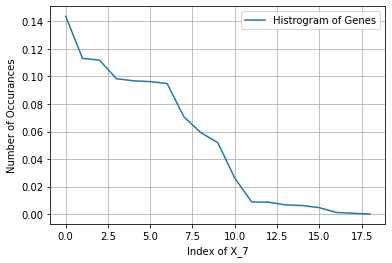

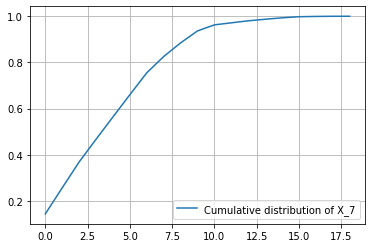

In [ ]:
feature_analysis('X_7')

Number of Unique values for feature X_8 is: 22
1     6950
0     5602
2     1432
3      602
4      274
5      148
6       49
7       25
8       19
10      17
Name: X_8, dtype: int64

There are 22 different categories of X_8 in train data, and they are distibuted as follows


Let us check the distribution of these unique features....


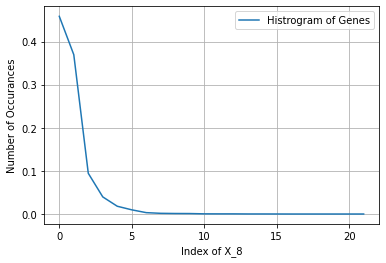

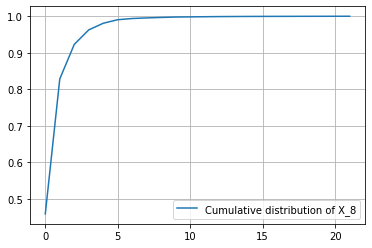

In [ ]:
feature_analysis('X_8')

Number of Unique values for feature X_9 is: 7
5    6697
6    6061
2    1948
3     280
1     100
0      62
4       3
Name: X_9, dtype: int64

There are 7 different categories of X_9 in train data, and they are distibuted as follows


Let us check the distribution of these unique features....


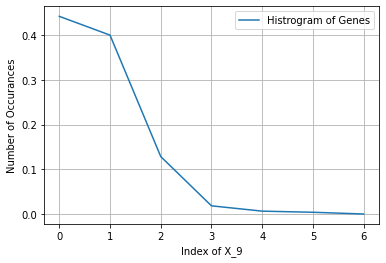

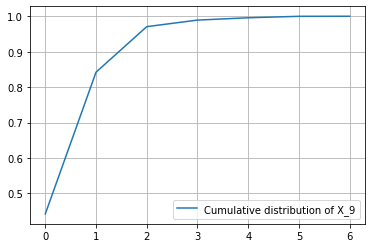

In [ ]:
feature_analysis('X_9')

Number of Unique values for feature X_10 is: 20
1     12810
2      1743
3       348
4       136
5        42
6        34
10       10
8         6
7         6
9         4
Name: X_10, dtype: int64

There are 20 different categories of X_10 in train data, and they are distibuted as follows


Let us check the distribution of these unique features....


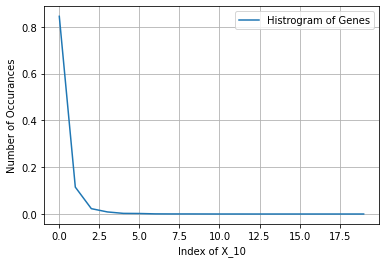

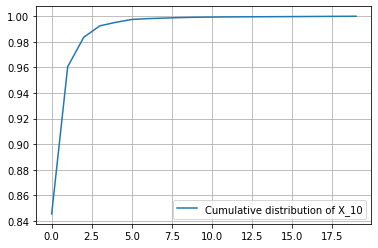

In [ ]:
feature_analysis('X_10')

Number of Unique values for feature X_11 is: 111
174    4518
249    4505
316    2872
0      1598
303     296
127     188
74      136
179     125
102      78
263      68
Name: X_11, dtype: int64

There are 111 different categories of X_11 in train data, and they are distibuted as follows


Let us check the distribution of these unique features....


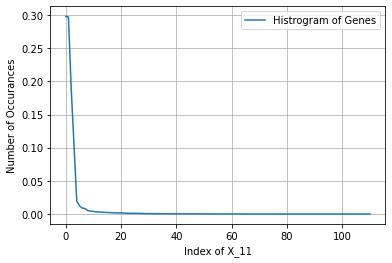

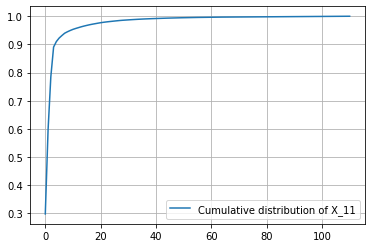

In [ ]:
feature_analysis('X_11')

Number of Unique values for feature X_12 is: 18
1.0     10047
0.0      3297
2.0      1322
3.0       289
4.0       110
5.0        35
6.0        25
8.0         5
10.0        5
9.0         4
Name: X_12, dtype: int64

There are 18 different categories of X_12 in train data, and they are distibuted as follows


Let us check the distribution of these unique features....


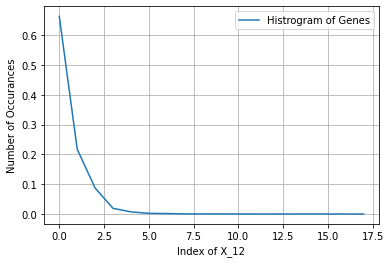

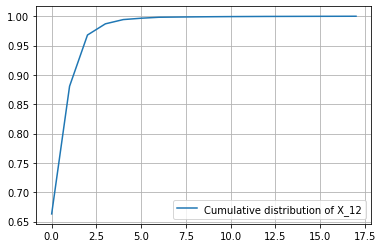

In [ ]:
feature_analysis('X_12')

Number of Unique values for feature X_13 is: 54
103    4469
72     2871
92     2048
112    1350
98      873
18      537
109     339
24      324
12      271
59      219
Name: X_13, dtype: int64

There are 54 different categories of X_13 in train data, and they are distibuted as follows


Let us check the distribution of these unique features....


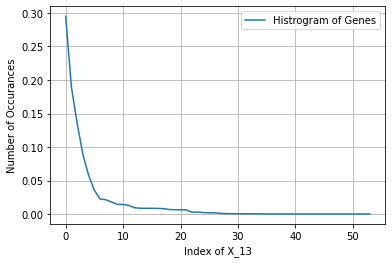

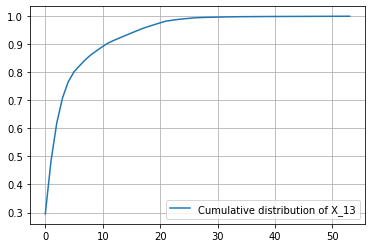

In [ ]:
feature_analysis('X_13')

Number of Unique values for feature X_14 is: 50
29     5250
93     1931
142    1740
62     1566
80      961
130     736
107     449
14      416
119     345
103     339
Name: X_14, dtype: int64

There are 50 different categories of X_14 in train data, and they are distibuted as follows


Let us check the distribution of these unique features....


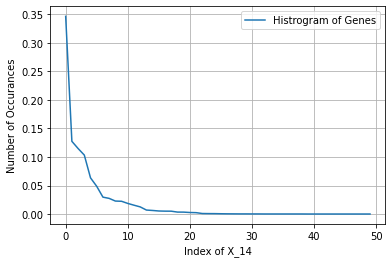

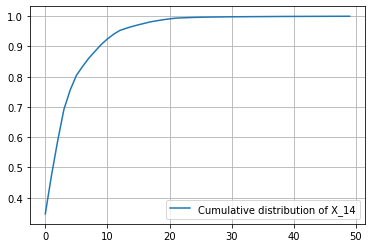

In [ ]:
feature_analysis('X_14')

Number of Unique values for feature X_15 is: 25
34    12129
43      869
0       640
46      417
23      391
48      334
36      128
50       94
9        54
39       36
Name: X_15, dtype: int64

There are 25 different categories of X_15 in train data, and they are distibuted as follows


Let us check the distribution of these unique features....


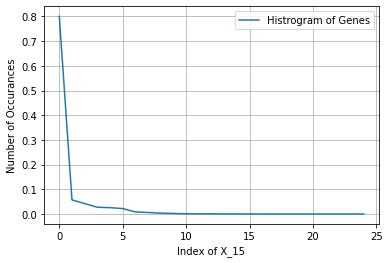

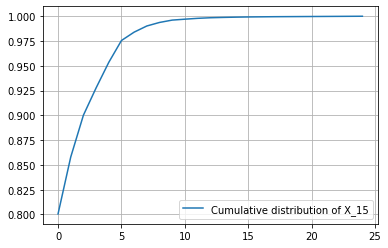

In [ ]:
feature_analysis('X_15')

Number of Unique values for feature dow is: 7
4    2334
0    2295
3    2143
1    2139
6    2096
5    2073
2    2071
Name: dow, dtype: int64

There are 7 different categories of dow in train data, and they are distibuted as follows


Let us check the distribution of these unique features....


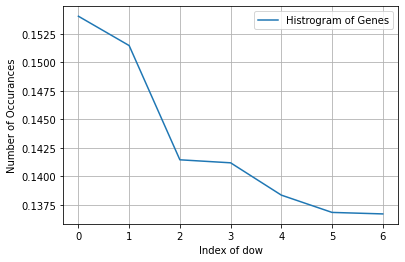

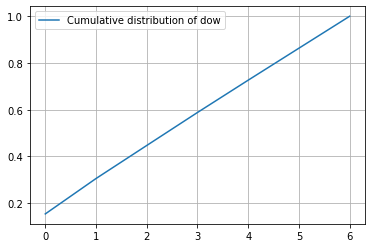

In [ ]:
feature_analysis('dow')

From all these plots for each of our variable we can say that, 20 % of labels contain somewhat 90% of data points....

Few variables have equal(almost) distibution of data apart from 1-2 categories...

All these seems to be good predictor for our problem....

Let us start by encoding our categorical variables....

Will encode our categorical variables using 2 methods:
1. One Hot Encoding
2. Response Encoding

We will try various models and see which performs the best, for this we are going to follow 2 different encoding approaches, one is the one hot encoding which gives sparse vector equal to the number of levels for a particular category, other one is response encoding which gives us a vector of 2 for each category of the categorical variable....

Since with one hot encoding we do get a sparse matrix with greater dimensions, we will be using this encoding to train LR, SVM and even RF.....

Response Encoding will be used with K-NN, K-NN is a powerful method for classification, but one drawback is that, will more data points and higher dimensions this algo takes a lot of time to train, in our case we don't have large data points and with response encoding the overall dimension will be less, we will use this with K-NN, also, we will be training response encoded vectors using RF.

In [ ]:
train_df.columns

Index(['X_1', 'X_2', 'X_4', 'X_5', 'X_7', 'X_8', 'X_9', 'X_10', 'X_11', 'X_12',
       'X_13', 'X_14', 'X_15', 'MULTIPLE_OFFENSE', 'dow', 'is_weekend'],
      dtype='object')

**Helper function for encoding variables**

In [ ]:
#Response encoding
def fit_function(alpha, feature, data):
  value = data[feature].value_counts()
#  print(value)
  
  train_output = dict()
  
  for category, total_counts in value.items():
#    print(category,total_counts)
    vec = []
    for label in range(0,2):
      label_count = data.loc[(data['MULTIPLE_OFFENSE'] == label) & (data[feature] == category)]
 #     print(label_count)
      
      vec.append((label_count.shape[0] + alpha * 10) / (total_counts + 90 * alpha))
    train_output[category] = vec
  return train_output
      

def transform_function(fit_grade, feature, data):
  value = data[feature].value_counts()
  final_vector = []
  for index, row in data.iterrows():
    try:
      if row[feature] in dict(value).keys():
        final_vector.append(fit_grade[row[feature]])
      else:
        final_vector.append([1/2,1/2])
    except KeyError:
      final_vector.append([1/2,1/2])
  return np.array(final_vector)

**Creating vectors using Response Encoding**

In [ ]:
alpha = 1 #For smoothing
fit_X1 = fit_function(alpha, 'X_1',train_df)

In [ ]:
X1_response_encoding_train = transform_function(fit_X1, 'X_1',train_df)
X1_response_encoding_test = transform_function(fit_X1, 'X_1',test_df)
X1_response_encoding_cv = transform_function(fit_X1, 'X_1',cv_df)

In [ ]:
print(X1_response_encoding_train.shape, X1_response_encoding_test.shape, X1_response_encoding_cv.shape)

(15151, 2) (4735, 2) (3788, 2)


In [ ]:
print(X1_response_encoding_train[0:10])
print("-------------------------")
print(X1_response_encoding_test[0:10])
print("-------------------------")
print(X1_response_encoding_cv[0:10])

[[0.04534233 0.9488973 ]
 [0.04534233 0.9488973 ]
 [0.04534233 0.9488973 ]
 [0.05299145 0.91709402]
 [0.04534233 0.9488973 ]
 [0.04534233 0.9488973 ]
 [0.08148148 0.65925926]
 [0.05299145 0.91709402]
 [0.04534233 0.9488973 ]
 [0.05299145 0.91709402]]
-------------------------
[[0.05299145 0.91709402]
 [0.04534233 0.9488973 ]
 [0.04534233 0.9488973 ]
 [0.04534233 0.9488973 ]
 [0.04534233 0.9488973 ]
 [0.04534233 0.9488973 ]
 [0.05299145 0.91709402]
 [0.09433962 0.24528302]
 [0.04534233 0.9488973 ]
 [0.04534233 0.9488973 ]]
-------------------------
[[0.04534233 0.9488973 ]
 [0.04534233 0.9488973 ]
 [0.04534233 0.9488973 ]
 [0.04534233 0.9488973 ]
 [0.04534233 0.9488973 ]
 [0.05299145 0.91709402]
 [0.05299145 0.91709402]
 [0.04534233 0.9488973 ]
 [0.04534233 0.9488973 ]
 [0.04534233 0.9488973 ]]


In [ ]:
fit_X2 = fit_function(alpha, 'X_2',train_df)
X2_response_encoding_train = transform_function(fit_X2, 'X_2',train_df)
X2_response_encoding_test = transform_function(fit_X2, 'X_2',test_df)
X2_response_encoding_cv = transform_function(fit_X2, 'X_2',cv_df)
print(X2_response_encoding_train.shape, X2_response_encoding_test.shape, X2_response_encoding_cv.shape)

(15151, 2) (4735, 2) (3788, 2)


In [ ]:
fit_X4 = fit_function(alpha, 'X_4',train_df)
X4_response_encoding_train = transform_function(fit_X4, 'X_4',train_df)
X4_response_encoding_test = transform_function(fit_X4, 'X_4',test_df)
X4_response_encoding_cv = transform_function(fit_X4, 'X_4',cv_df)
print(X4_response_encoding_train.shape, X4_response_encoding_test.shape, X4_response_encoding_cv.shape)

(15151, 2) (4735, 2) (3788, 2)


In [ ]:
fit_X5 = fit_function(alpha, 'X_5',train_df)
X5_response_encoding_train = transform_function(fit_X5, 'X_5',train_df)
X5_response_encoding_test = transform_function(fit_X5, 'X_5',test_df)
X5_response_encoding_cv = transform_function(fit_X5, 'X_5',cv_df)
print(X5_response_encoding_train.shape, X5_response_encoding_test.shape, X5_response_encoding_cv.shape)

(15151, 2) (4735, 2) (3788, 2)


In [ ]:
fit_X7 = fit_function(alpha, 'X_7',train_df)
X7_response_encoding_train = transform_function(fit_X7, 'X_7',train_df)
X7_response_encoding_test = transform_function(fit_X7, 'X_7',test_df)
X7_response_encoding_cv = transform_function(fit_X7, 'X_7',cv_df)
print(X7_response_encoding_train.shape, X7_response_encoding_test.shape, X7_response_encoding_cv.shape)

(15151, 2) (4735, 2) (3788, 2)


In [ ]:
fit_X8 = fit_function(alpha, 'X_8',train_df)
X8_response_encoding_train = transform_function(fit_X8, 'X_8',train_df)
X8_response_encoding_test = transform_function(fit_X8, 'X_8',test_df)
X8_response_encoding_cv = transform_function(fit_X8, 'X_8',cv_df)
print(X8_response_encoding_train.shape, X8_response_encoding_test.shape, X8_response_encoding_cv.shape)

(15151, 2) (4735, 2) (3788, 2)


In [ ]:
fit_X9 = fit_function(alpha, 'X_9',train_df)
X9_response_encoding_train = transform_function(fit_X9, 'X_9',train_df)
X9_response_encoding_test = transform_function(fit_X9, 'X_9',test_df)
X9_response_encoding_cv = transform_function(fit_X9, 'X_9',cv_df)
print(X9_response_encoding_train.shape, X9_response_encoding_test.shape, X9_response_encoding_cv.shape)

(15151, 2) (4735, 2) (3788, 2)


In [ ]:
fit_X10 = fit_function(alpha, 'X_10',train_df)
X10_response_encoding_train = transform_function(fit_X10, 'X_10',train_df)
X10_response_encoding_test = transform_function(fit_X10, 'X_10',test_df)
X10_response_encoding_cv = transform_function(fit_X10, 'X_10',cv_df)
print(X10_response_encoding_train.shape, X10_response_encoding_test.shape, X10_response_encoding_cv.shape)

(15151, 2) (4735, 2) (3788, 2)


In [ ]:
fit_X11 = fit_function(alpha, 'X_11',train_df)
X11_response_encoding_train = transform_function(fit_X11, 'X_11',train_df)
X11_response_encoding_test = transform_function(fit_X11, 'X_11',test_df)
X11_response_encoding_cv = transform_function(fit_X11, 'X_11',cv_df)
print(X11_response_encoding_train.shape, X11_response_encoding_test.shape, X11_response_encoding_cv.shape)

(15151, 2) (4735, 2) (3788, 2)


In [ ]:
fit_X12 = fit_function(alpha, 'X_12',train_df)
X12_response_encoding_train = transform_function(fit_X12, 'X_12',train_df)
X12_response_encoding_test = transform_function(fit_X12, 'X_12',test_df)
X12_response_encoding_cv = transform_function(fit_X12, 'X_12',cv_df)
print(X12_response_encoding_train.shape, X12_response_encoding_test.shape, X12_response_encoding_cv.shape)

(15151, 2) (4735, 2) (3788, 2)


In [ ]:
fit_X13 = fit_function(alpha, 'X_13',train_df)
X13_response_encoding_train = transform_function(fit_X13, 'X_13',train_df)
X13_response_encoding_test = transform_function(fit_X13, 'X_13',test_df)
X13_response_encoding_cv = transform_function(fit_X13, 'X_13',cv_df)
print(X13_response_encoding_train.shape, X13_response_encoding_test.shape, X13_response_encoding_cv.shape)

(15151, 2) (4735, 2) (3788, 2)


In [ ]:
fit_X14 = fit_function(alpha, 'X_14',train_df)
X14_response_encoding_train = transform_function(fit_X14, 'X_14',train_df)
X14_response_encoding_test = transform_function(fit_X14, 'X_14',test_df)
X14_response_encoding_cv = transform_function(fit_X14, 'X_14',cv_df)
print(X14_response_encoding_train.shape, X14_response_encoding_test.shape, X14_response_encoding_cv.shape)

(15151, 2) (4735, 2) (3788, 2)


In [ ]:
fit_X15 = fit_function(alpha, 'X_15',train_df)
X15_response_encoding_train = transform_function(fit_X15, 'X_15',train_df)
X15_response_encoding_test = transform_function(fit_X15, 'X_15',test_df)
X15_response_encoding_cv = transform_function(fit_X15, 'X_15',cv_df)
print(X15_response_encoding_train.shape, X15_response_encoding_test.shape, X15_response_encoding_cv.shape)

(15151, 2) (4735, 2) (3788, 2)


In [ ]:
fit_dow = fit_function(alpha, 'dow',train_df)
dow_response_encoding_train = transform_function(fit_dow, 'dow',train_df)
dow_response_encoding_test = transform_function(fit_dow, 'dow',test_df)
dow_response_encoding_cv = transform_function(fit_dow, 'dow',cv_df)
print(dow_response_encoding_train.shape, dow_response_encoding_test.shape, dow_response_encoding_cv.shape)

(15151, 2) (4735, 2) (3788, 2)


<h2> Creating vectors using one hot encoding </h2>

In [ ]:
from sklearn.feature_extraction.text import CountVectorizer
X1_vectorizer = CountVectorizer(vocabulary=train_df['X_1'].unique(), lowercase=False)
print(X1_vectorizer.get_feature_names())

['0', '1', '5', '7', '4', '3', '2', '6']


In [ ]:
train_x1_feature_onehotCoding = X1_vectorizer.fit_transform(train_df['X_1'])
test_x1_feature_onehotCoding = X1_vectorizer.transform(test_df['X_1'])
cv_x1_feature_onehotCoding = X1_vectorizer.transform(cv_df['X_1'])

In [ ]:
X2_vectorizer = CountVectorizer(vocabulary=train_df['X_2'].unique(), lowercase=False)
train_x2_feature_onehotCoding = X2_vectorizer.fit_transform(train_df['X_2'])
test_x2_feature_onehotCoding = X2_vectorizer.transform(test_df['X_2'])
cv_x2_feature_onehotCoding = X2_vectorizer.transform(cv_df['X_2'])

In [ ]:
X4_vectorizer = CountVectorizer(vocabulary=train_df['X_4'].unique(), lowercase=False)
train_x4_feature_onehotCoding = X4_vectorizer.fit_transform(train_df['X_4'])
test_x4_feature_onehotCoding = X4_vectorizer.transform(test_df['X_4'])
cv_x4_feature_onehotCoding = X4_vectorizer.transform(cv_df['X_4'])

In [ ]:
X5_vectorizer = CountVectorizer(vocabulary=train_df['X_5'].unique(), lowercase=False)
train_x5_feature_onehotCoding = X5_vectorizer.fit_transform(train_df['X_5'])
test_x5_feature_onehotCoding = X5_vectorizer.transform(test_df['X_5'])
cv_x5_feature_onehotCoding = X5_vectorizer.transform(cv_df['X_5'])

In [ ]:
X7_vectorizer = CountVectorizer(vocabulary=train_df['X_7'].unique(), lowercase=False)
train_x7_feature_onehotCoding = X7_vectorizer.fit_transform(train_df['X_7'])
test_x7_feature_onehotCoding = X7_vectorizer.transform(test_df['X_7'])
cv_x7_feature_onehotCoding = X7_vectorizer.transform(cv_df['X_7'])

In [ ]:
X8_vectorizer = CountVectorizer(vocabulary=train_df['X_8'].unique(), lowercase=False)
train_x8_feature_onehotCoding = X8_vectorizer.fit_transform(train_df['X_8'])
test_x8_feature_onehotCoding = X8_vectorizer.transform(test_df['X_8'])
cv_x8_feature_onehotCoding = X8_vectorizer.transform(cv_df['X_8'])

In [ ]:
X9_vectorizer = CountVectorizer(vocabulary=train_df['X_9'].unique(), lowercase=False)
train_x9_feature_onehotCoding = X9_vectorizer.fit_transform(train_df['X_9'])
test_x9_feature_onehotCoding = X9_vectorizer.transform(test_df['X_9'])
cv_x9_feature_onehotCoding = X9_vectorizer.transform(cv_df['X_9'])

In [ ]:
X10_vectorizer = CountVectorizer(vocabulary=train_df['X_10'].unique(), lowercase=False)
train_x10_feature_onehotCoding = X10_vectorizer.fit_transform(train_df['X_10'])
test_x10_feature_onehotCoding = X10_vectorizer.transform(test_df['X_10'])
cv_x10_feature_onehotCoding = X10_vectorizer.transform(cv_df['X_10'])

In [ ]:
X11_vectorizer = CountVectorizer(vocabulary=train_df['X_11'].unique(), lowercase=False)
train_x11_feature_onehotCoding = X11_vectorizer.fit_transform(train_df['X_11'])
test_x11_feature_onehotCoding = X11_vectorizer.transform(test_df['X_11'])
cv_x11_feature_onehotCoding = X11_vectorizer.transform(cv_df['X_11'])

In [ ]:
X12_vectorizer = CountVectorizer(vocabulary=train_df['X_12'].unique(), lowercase=False)
train_x12_feature_onehotCoding = X12_vectorizer.fit_transform(train_df['X_12'])
test_x12_feature_onehotCoding = X12_vectorizer.transform(test_df['X_12'])
cv_x12_feature_onehotCoding = X12_vectorizer.transform(cv_df['X_12'])

In [ ]:
X13_vectorizer = CountVectorizer(vocabulary=train_df['X_13'].unique(), lowercase=False)
train_x13_feature_onehotCoding = X13_vectorizer.fit_transform(train_df['X_13'])
test_x13_feature_onehotCoding = X13_vectorizer.transform(test_df['X_13'])
cv_x13_feature_onehotCoding = X13_vectorizer.transform(cv_df['X_13'])

In [ ]:
X14_vectorizer = CountVectorizer(vocabulary=train_df['X_14'].unique(), lowercase=False)
train_x14_feature_onehotCoding = X14_vectorizer.fit_transform(train_df['X_14'])
test_x14_feature_onehotCoding = X14_vectorizer.transform(test_df['X_14'])
cv_x14_feature_onehotCoding = X14_vectorizer.transform(cv_df['X_14'])

In [ ]:
X15_vectorizer = CountVectorizer(vocabulary=train_df['X_15'].unique(), lowercase=False)
train_x15_feature_onehotCoding = X15_vectorizer.fit_transform(train_df['X_15'])
test_x15_feature_onehotCoding = X15_vectorizer.transform(test_df['X_15'])
cv_x15_feature_onehotCoding = X15_vectorizer.transform(cv_df['X_15'])

In [ ]:
dow_vectorizer = CountVectorizer(vocabulary=train_df['dow'].unique(), lowercase=False)
train_dow_feature_onehotCoding = dow_vectorizer.fit_transform(train_df['dow'])
test_dow_feature_onehotCoding = dow_vectorizer.transform(test_df['dow'])
cv_dow_feature_onehotCoding = dow_vectorizer.transform(cv_df['dow'])

**Stacking our features**

In [ ]:
from scipy.sparse import hstack
X_train_onehot = hstack((train_x1_feature_onehotCoding, train_x2_feature_onehotCoding, train_x4_feature_onehotCoding, train_x5_feature_onehotCoding, train_x7_feature_onehotCoding, train_x8_feature_onehotCoding, train_x9_feature_onehotCoding, train_x10_feature_onehotCoding, train_x11_feature_onehotCoding, train_x12_feature_onehotCoding, train_x13_feature_onehotCoding, train_x14_feature_onehotCoding, train_x15_feature_onehotCoding, train_dow_feature_onehotCoding, train_df['is_weekend'].values.reshape(-1, 1))).tocsr()
X_test_onehot = hstack((test_x1_feature_onehotCoding, test_x2_feature_onehotCoding, test_x4_feature_onehotCoding, test_x5_feature_onehotCoding, test_x7_feature_onehotCoding, test_x8_feature_onehotCoding, test_x9_feature_onehotCoding, test_x10_feature_onehotCoding, test_x11_feature_onehotCoding, test_x12_feature_onehotCoding, test_x13_feature_onehotCoding, test_x14_feature_onehotCoding, test_x15_feature_onehotCoding, test_dow_feature_onehotCoding, test_df['is_weekend'].values.reshape(-1, 1))).tocsr()
X_cv_onehot = hstack((cv_x1_feature_onehotCoding, cv_x2_feature_onehotCoding, cv_x4_feature_onehotCoding, cv_x5_feature_onehotCoding, cv_x7_feature_onehotCoding, cv_x8_feature_onehotCoding, cv_x9_feature_onehotCoding, cv_x10_feature_onehotCoding, cv_x11_feature_onehotCoding, cv_x12_feature_onehotCoding, cv_x13_feature_onehotCoding, cv_x14_feature_onehotCoding, cv_x15_feature_onehotCoding, cv_dow_feature_onehotCoding, cv_df['is_weekend'].values.reshape(-1, 1))).tocsr()

In [ ]:
print(X_train_onehot.shape, X_test_onehot.shape, X_cv_onehot.shape)

(15151, 409) (4735, 409) (3788, 409)


In [ ]:
from numpy import hstack
X_train_response = hstack((X1_response_encoding_train, X2_response_encoding_train, X4_response_encoding_train, X5_response_encoding_train, X7_response_encoding_train, X8_response_encoding_train, X9_response_encoding_train, X10_response_encoding_train, X11_response_encoding_train, X12_response_encoding_train, X13_response_encoding_train, X14_response_encoding_train, X15_response_encoding_train, dow_response_encoding_train, train_df['is_weekend'].values.reshape(-1, 1)))
X_test_response = hstack((X1_response_encoding_test, X2_response_encoding_test, X4_response_encoding_test, X5_response_encoding_test, X7_response_encoding_test, X8_response_encoding_test, X9_response_encoding_test, X10_response_encoding_test, X11_response_encoding_test, X12_response_encoding_test, X13_response_encoding_test, X14_response_encoding_test, X15_response_encoding_test, dow_response_encoding_test, test_df['is_weekend'].values.reshape(-1, 1)))
X_cv_response = hstack((X1_response_encoding_cv, X2_response_encoding_cv, X4_response_encoding_cv, X5_response_encoding_cv, X7_response_encoding_cv, X8_response_encoding_cv, X9_response_encoding_cv, X10_response_encoding_cv, X11_response_encoding_cv, X12_response_encoding_cv, X13_response_encoding_cv, X14_response_encoding_cv, X15_response_encoding_cv, dow_response_encoding_cv, cv_df['is_weekend'].values.reshape(-1, 1)))

In [ ]:
print(X_train_response.shape, X_test_response.shape, X_cv_response.shape)

(15151, 29) (4735, 29) (3788, 29)


In [ ]:
train_y = np.array(list(train_df['MULTIPLE_OFFENSE']))
test_y = np.array(list(test_df['MULTIPLE_OFFENSE']))
cv_y = np.array(list(cv_df['MULTIPLE_OFFENSE']))

In [ ]:
print(train_y.shape, test_y.shape, cv_y.shape)

(15151,) (4735,) (3788,)


<h2> Helper Function for our model </h2>

We will be using log loss during hyper parameter tuning, as it penalizes more for any false prediction.

Also, along with this, we will be checking the confusion matrix, precision matrix and recall matrix using prediction given by our model using after hyperparam tuning

In [ ]:
# This function plots the confusion matrices given y_i, y_i_hat.
def plot_confusion_matrix(test_y, predict_y):
    C = confusion_matrix(test_y, predict_y)
    A =(((C.T)/(C.sum(axis=1))).T) #Recall
    B =(C/C.sum(axis=0)) #Precision
    
    labels = [0, 1]
    print("-"*20, "Confusion matrix", "-"*20)
    plt.figure(figsize=(10,5))
    sns.heatmap(C, annot=True, cmap="YlGnBu", fmt=".3f", xticklabels=labels, yticklabels=labels)
    plt.xlabel('Predicted Class')
    plt.ylabel('Original Class')
    plt.show()

    print("-"*20, "Precision matrix (Columm Sum=1)", "-"*20)
    plt.figure(figsize=(10,5))
    sns.heatmap(B, annot=True, cmap="YlGnBu", fmt=".3f", xticklabels=labels, yticklabels=labels)
    plt.xlabel('Predicted Class')
    plt.ylabel('Original Class')
    plt.show()
    
    print("-"*20, "Recall matrix (Row sum=1)", "-"*20)
    plt.figure(figsize=(10,5))
    sns.heatmap(A, annot=True, cmap="YlGnBu", fmt=".3f", xticklabels=labels, yticklabels=labels)
    plt.xlabel('Predicted Class')
    plt.ylabel('Original Class')
    plt.show()

In [ ]:
def predict_and_plot_confusion_matrix(train_x, train_y,test_x, test_y, clf):
    clf.fit(train_x, train_y)
    sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
    sig_clf.fit(train_x, train_y)
    pred_y = sig_clf.predict(test_x)

    # for calculating log_loss we will provide the array of probabilities belongs to each class
    print("Log loss :",log_loss(test_y, sig_clf.predict_proba(test_x)))
    # calculating the number of data points that are misclassified
    print("Number of mis-classified points :", np.count_nonzero((pred_y- test_y))/test_y.shape[0])
    plot_confusion_matrix(test_y, pred_y)

def report_log_loss(train_x, train_y, test_x, test_y,  clf):
    clf.fit(train_x, train_y)
    sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
    sig_clf.fit(train_x, train_y)
    sig_clf_probs = sig_clf.predict_proba(test_x)
    return log_loss(test_y, sig_clf_probs, eps=1e-15)

<h1> K-NN </h1>

<h2> Hyper param tuning </h2>

for k = 5
Log Loss : 0.005000116710971681
for k = 11
Log Loss : 0.003988299692032297
for k = 15
Log Loss : 0.004348153298224244
for k = 21
Log Loss : 0.005129885046250511
for k = 31
Log Loss : 0.006059268541240273
for k = 41
Log Loss : 0.0063223075200229024
for k = 51
Log Loss : 0.006215347055209896
for k = 99
Log Loss : 0.005651460458632227


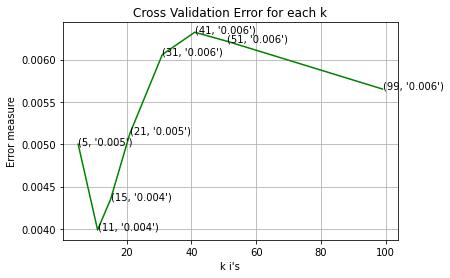

For values of best k =  11 The train log loss is: 0.00272300486327239
For values of best k =  11 The cross validation log loss is: 0.003988299692032297
For values of best k =  11 The test log loss is: 0.0022746663176355956


In [ ]:
k = [5, 11, 15, 21, 31, 41, 51, 99]
cv_log_error_array = []
for i in k:
    print("for k =", i)
    clf = KNeighborsClassifier(n_neighbors=i)
    clf.fit(X_train_response, train_y)
    sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
    sig_clf.fit(X_train_response, train_y)
    sig_clf_probs = sig_clf.predict_proba(X_cv_response)
    cv_log_error_array.append(log_loss(cv_y, sig_clf_probs, labels=clf.classes_, eps=1e-15))
    # to avoid rounding error while multiplying probabilites we use log-probability estimates
    print("Log Loss :",log_loss(cv_y, sig_clf_probs)) 

fig, ax = plt.subplots()
ax.plot(k, cv_log_error_array,c='g')
for i, txt in enumerate(np.round(cv_log_error_array,3)):
    ax.annotate((k[i],str(txt)), (k[i],cv_log_error_array[i]))
plt.grid()
plt.title("Cross Validation Error for each k")
plt.xlabel("k i's")
plt.ylabel("Error measure")
plt.show()


best_k = np.argmin(cv_log_error_array)
clf = KNeighborsClassifier(n_neighbors=k[best_k])
clf.fit(X_train_response, train_y)
sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
sig_clf.fit(X_train_response, train_y)

predict_y = sig_clf.predict_proba(X_train_response)
print('For values of best k = ', k[best_k], "The train log loss is:",log_loss(train_y, predict_y, labels=clf.classes_, eps=1e-15))
predict_y = sig_clf.predict_proba(X_cv_response)
print('For values of best k = ', k[best_k], "The cross validation log loss is:",log_loss(cv_y, predict_y, labels=clf.classes_, eps=1e-15))
predict_y = sig_clf.predict_proba(X_test_response)
print('For values of best k = ', k[best_k], "The test log loss is:",log_loss(test_y, predict_y, labels=clf.classes_, eps=1e-15))


<h2> Using tuned value to plot matrix on test data </h2>

Log loss : 0.0022746663176355956
Number of mis-classified points : 0.00042238648363252375
-------------------- Confusion matrix --------------------


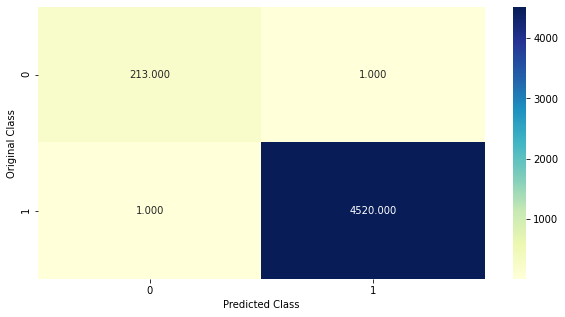

-------------------- Precision matrix (Columm Sum=1) --------------------


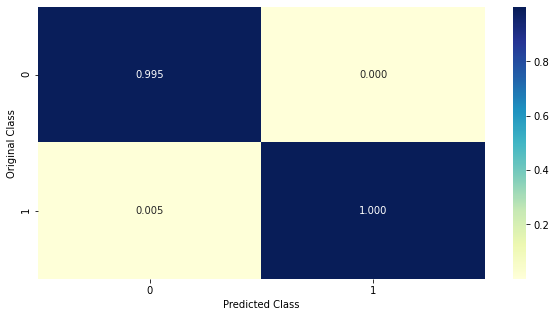

-------------------- Recall matrix (Row sum=1) --------------------


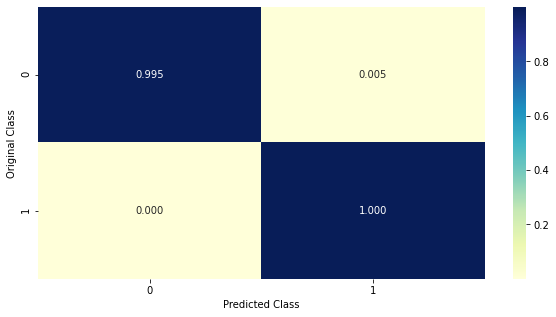

In [ ]:
clf = KNeighborsClassifier(n_neighbors=k[best_k])
predict_and_plot_confusion_matrix(X_train_response, train_y, X_test_response, test_y, clf)

K-NN with response encoding did a great jonb on test data, Only 2 missclassified points as per confusion matrix, and precision, recall matrix looks great....

<h1> Logistic Regression </h1>

**With Class Balancing**

**Hyperparameter tuning**

for alpha = 1e-06
Log Loss : 0.03574885043625657
for alpha = 1e-05
Log Loss : 0.03769053210826922
for alpha = 0.0001
Log Loss : 0.031625859211018785
for alpha = 0.001
Log Loss : 0.03964390552392174
for alpha = 0.01
Log Loss : 0.06235943710465008
for alpha = 0.1
Log Loss : 0.09457711566248496
for alpha = 1
Log Loss : 0.12525410385682545
for alpha = 10
Log Loss : 0.1316016930755278
for alpha = 100
Log Loss : 0.13235636276127863


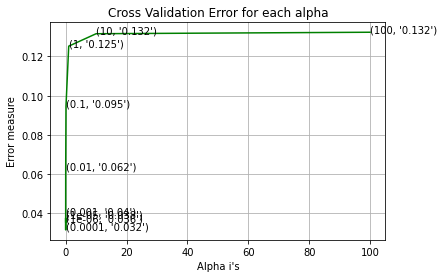

For values of best alpha =  0.0001 The train log loss is: 0.016864042004276186
For values of best alpha =  0.0001 The cross validation log loss is: 0.031625859211018785
For values of best alpha =  0.0001 The test log loss is: 0.02589377579847321


In [ ]:
alpha = [10 ** x for x in range(-6, 3)]
cv_log_error_array = []
for i in alpha:
    print("for alpha =", i)
    clf = SGDClassifier(class_weight='balanced', alpha=i, penalty='l2', loss='log', random_state=42)
    clf.fit(X_train_onehot, train_y)
    sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
    sig_clf.fit(X_train_onehot, train_y)
    sig_clf_probs = sig_clf.predict_proba(X_cv_onehot)
    cv_log_error_array.append(log_loss(cv_y, sig_clf_probs, labels=clf.classes_, eps=1e-15))
    # to avoid rounding error while multiplying probabilites we use log-probability estimates
    print("Log Loss :",log_loss(cv_y, sig_clf_probs)) 

fig, ax = plt.subplots()
ax.plot(alpha, cv_log_error_array,c='g')
for i, txt in enumerate(np.round(cv_log_error_array,3)):
    ax.annotate((alpha[i],str(txt)), (alpha[i],cv_log_error_array[i]))
plt.grid()
plt.title("Cross Validation Error for each alpha")
plt.xlabel("Alpha i's")
plt.ylabel("Error measure")
plt.show()


best_alpha = np.argmin(cv_log_error_array)
clf = SGDClassifier(class_weight='balanced', alpha=alpha[best_alpha], penalty='l2', loss='log', random_state=42)
clf.fit(X_train_onehot, train_y)
sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
sig_clf.fit(X_train_onehot, train_y)

predict_y = sig_clf.predict_proba(X_train_onehot)
print('For values of best alpha = ', alpha[best_alpha], "The train log loss is:",log_loss(train_y, predict_y, labels=clf.classes_, eps=1e-15))
predict_y = sig_clf.predict_proba(X_cv_onehot)
print('For values of best alpha = ', alpha[best_alpha], "The cross validation log loss is:",log_loss(cv_y, predict_y, labels=clf.classes_, eps=1e-15))
predict_y = sig_clf.predict_proba(X_test_onehot)
print('For values of best alpha = ', alpha[best_alpha], "The test log loss is:",log_loss(test_y, predict_y, labels=clf.classes_, eps=1e-15))

**Training Using the best value**

Log loss : 0.02589377579847321
Number of mis-classified points : 0.00781414994720169
-------------------- Confusion matrix --------------------


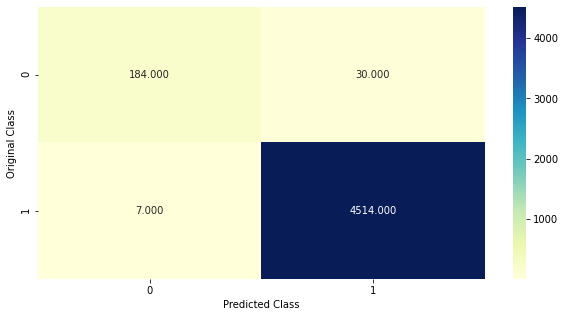

-------------------- Precision matrix (Columm Sum=1) --------------------


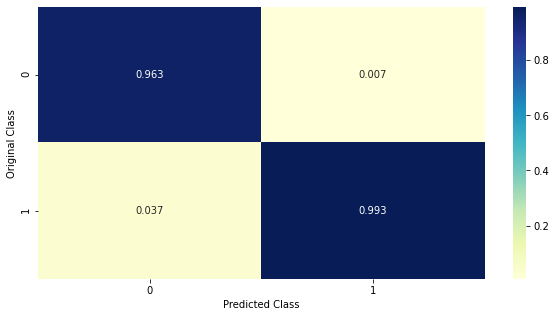

-------------------- Recall matrix (Row sum=1) --------------------


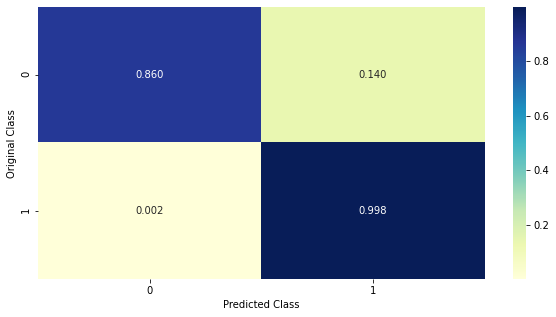

In [ ]:
clf = SGDClassifier(class_weight='balanced', alpha=alpha[best_alpha], penalty='l2', loss='log', random_state=42)
predict_and_plot_confusion_matrix(X_train_onehot, train_y, X_test_onehot, test_y, clf)

There were 7 points that were actually 0 and model predicted them to be 1, 30 points falls under FN category, precision values are ok, but recall for negative class is less....

**Without Class Balancing**

Hyperparameter tuning

for alpha = 1e-06
Log Loss : 0.02998395626095715
for alpha = 1e-05
Log Loss : 0.02739325751202262
for alpha = 0.0001
Log Loss : 0.03177372010136879
for alpha = 0.001
Log Loss : 0.053256173937152325
for alpha = 0.01
Log Loss : 0.12309030805923775
for alpha = 0.1
Log Loss : 0.1625799989118167
for alpha = 1
Log Loss : 0.17025626869237193
for alpha = 10
Log Loss : 0.17142067381597104
for alpha = 100
Log Loss : 0.1715436437608984


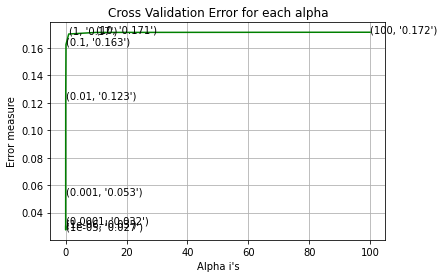

For values of best alpha =  1e-05 The train log loss is: 0.012585592726876687
For values of best alpha =  1e-05 The cross validation log loss is: 0.02739325751202262
For values of best alpha =  1e-05 The test log loss is: 0.02177836902935406


In [ ]:
alpha = [10 ** x for x in range(-6, 3)]
cv_log_error_array = []
for i in alpha:
    print("for alpha =", i)
    clf = SGDClassifier(alpha=i, penalty='l2', loss='log', random_state=42)
    clf.fit(X_train_onehot, train_y)
    sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
    sig_clf.fit(X_train_onehot, train_y)
    sig_clf_probs = sig_clf.predict_proba(X_cv_onehot)
    cv_log_error_array.append(log_loss(cv_y, sig_clf_probs, labels=clf.classes_, eps=1e-15))
    # to avoid rounding error while multiplying probabilites we use log-probability estimates
    print("Log Loss :",log_loss(cv_y, sig_clf_probs)) 

fig, ax = plt.subplots()
ax.plot(alpha, cv_log_error_array,c='g')
for i, txt in enumerate(np.round(cv_log_error_array,3)):
    ax.annotate((alpha[i],str(txt)), (alpha[i],cv_log_error_array[i]))
plt.grid()
plt.title("Cross Validation Error for each alpha")
plt.xlabel("Alpha i's")
plt.ylabel("Error measure")
plt.show()


best_alpha = np.argmin(cv_log_error_array)
clf = SGDClassifier(alpha=alpha[best_alpha], penalty='l2', loss='log', random_state=42)
clf.fit(X_train_onehot, train_y)
sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
sig_clf.fit(X_train_onehot, train_y)

predict_y = sig_clf.predict_proba(X_train_onehot)
print('For values of best alpha = ', alpha[best_alpha], "The train log loss is:",log_loss(y_train, predict_y, labels=clf.classes_, eps=1e-15))
predict_y = sig_clf.predict_proba(X_cv_onehot)
print('For values of best alpha = ', alpha[best_alpha], "The cross validation log loss is:",log_loss(y_cv, predict_y, labels=clf.classes_, eps=1e-15))
predict_y = sig_clf.predict_proba(X_test_onehot)
print('For values of best alpha = ', alpha[best_alpha], "The test log loss is:",log_loss(y_test, predict_y, labels=clf.classes_, eps=1e-15))

Log loss : 0.02177836902935406
Number of mis-classified points : 0.005913410770855333
-------------------- Confusion matrix --------------------


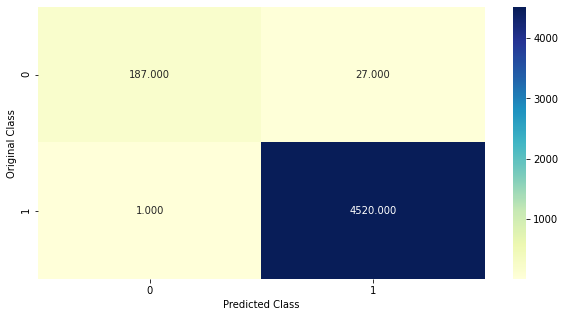

-------------------- Precision matrix (Columm Sum=1) --------------------


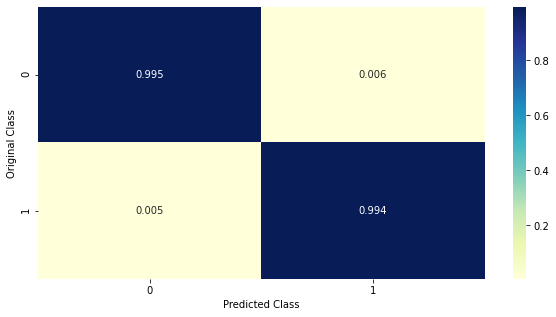

-------------------- Recall matrix (Row sum=1) --------------------


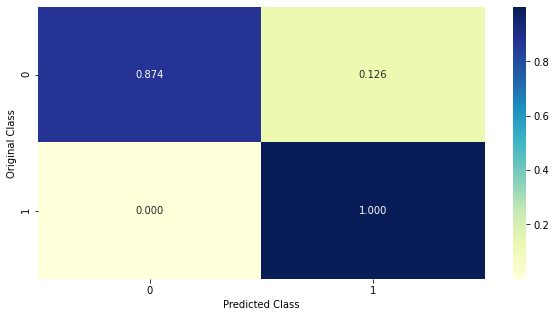

In [ ]:
clf = SGDClassifier(alpha=alpha[best_alpha], penalty='l2', loss='log', random_state=42)
predict_and_plot_confusion_matrix(X_train_onehot, train_y, X_test_onehot, test_y, clf)

Results have improved, but again not better than k-nn, recall for negative class is again less....

<h2> Linear SVM (balanced class weight)</h2>

**Hyperparam tuning**

for C = 1e-05
Log Loss : 0.03547373481369046
for C = 0.0001
Log Loss : 0.03564039467920795
for C = 0.001
Log Loss : 0.036340987462017395
for C = 0.01
Log Loss : 0.05195252416795161
for C = 0.1
Log Loss : 0.07921484003408973
for C = 1
Log Loss : 0.13247820570895635
for C = 10
Log Loss : 0.1324812424581082
for C = 100
Log Loss : 0.13248124233375555


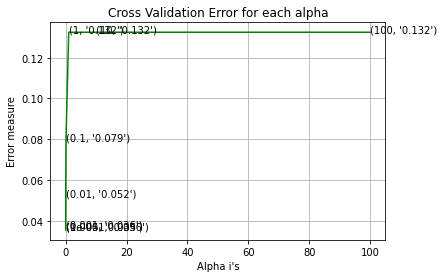

For values of best alpha =  1e-05 The train log loss is: 0.020150535433533154
For values of best alpha =  1e-05 The cross validation log loss is: 0.03547373481369046
For values of best alpha =  1e-05 The test log loss is: 0.030184999382242596


In [ ]:
alpha = [10 ** x for x in range(-5, 3)]
cv_log_error_array = []
for i in alpha:
    print("for C =", i)
#     clf = SVC(C=i,kernel='linear',probability=True, class_weight='balanced')
    clf = SGDClassifier( class_weight='balanced', alpha=i, penalty='l2', loss='hinge', random_state=42)
    clf.fit(X_train_onehot, train_y)
    sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
    sig_clf.fit(X_train_onehot, train_y)
    sig_clf_probs = sig_clf.predict_proba(X_cv_onehot)
    cv_log_error_array.append(log_loss(cv_y, sig_clf_probs, labels=clf.classes_, eps=1e-15))
    print("Log Loss :",log_loss(cv_y, sig_clf_probs)) 

fig, ax = plt.subplots()
ax.plot(alpha, cv_log_error_array,c='g')
for i, txt in enumerate(np.round(cv_log_error_array,3)):
    ax.annotate((alpha[i],str(txt)), (alpha[i],cv_log_error_array[i]))
plt.grid()
plt.title("Cross Validation Error for each alpha")
plt.xlabel("Alpha i's")
plt.ylabel("Error measure")
plt.show()


best_alpha = np.argmin(cv_log_error_array)
# clf = SVC(C=i,kernel='linear',probability=True, class_weight='balanced')
clf = SGDClassifier(class_weight='balanced', alpha=alpha[best_alpha], penalty='l2', loss='hinge', random_state=42)
clf.fit(X_train_onehot, train_y)
sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
sig_clf.fit(X_train_onehot, train_y)

predict_y = sig_clf.predict_proba(X_train_onehot)
print('For values of best alpha = ', alpha[best_alpha], "The train log loss is:",log_loss(y_train, predict_y, labels=clf.classes_, eps=1e-15))
predict_y = sig_clf.predict_proba(X_cv_onehot)
print('For values of best alpha = ', alpha[best_alpha], "The cross validation log loss is:",log_loss(y_cv, predict_y, labels=clf.classes_, eps=1e-15))
predict_y = sig_clf.predict_proba(X_test_onehot)
print('For values of best alpha = ', alpha[best_alpha], "The test log loss is:",log_loss(y_test, predict_y, labels=clf.classes_, eps=1e-15))

Log loss : 0.030184999382242596
Number of mis-classified points : 0.009503695881731784
-------------------- Confusion matrix --------------------


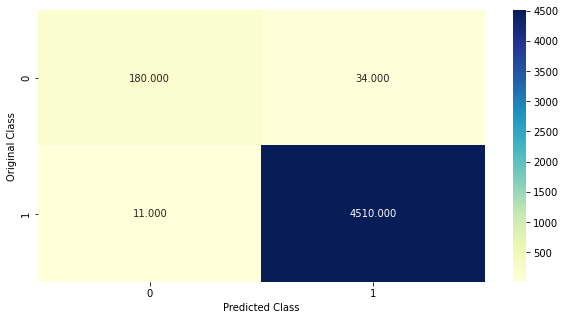

-------------------- Precision matrix (Columm Sum=1) --------------------


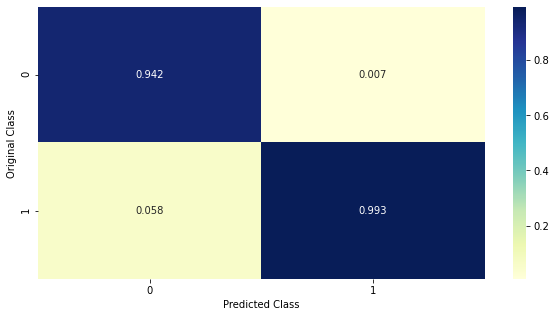

-------------------- Recall matrix (Row sum=1) --------------------


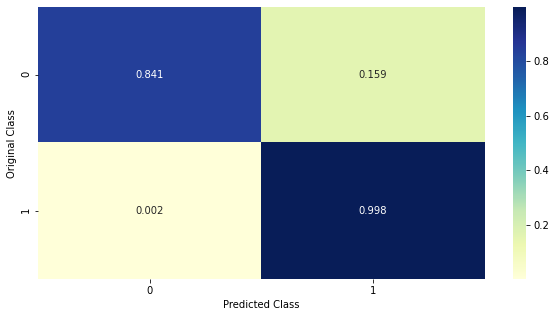

In [ ]:
clf = SGDClassifier(alpha=alpha[best_alpha], penalty='l2', loss='hinge', random_state=42,class_weight='balanced')
predict_and_plot_confusion_matrix(X_train_onehot, train_y,X_test_onehot, test_y, clf)

Worst of all the model we have seen till now, with more number of FN and FP values, recall and precision for negative class are less....

<h2> Linear SVM (unbalanced class weight)</h2>

**Hyperparam tuning**

for C = 1e-05
Log Loss : 0.027495796313037953
for C = 0.0001
Log Loss : 0.027401511659601474
for C = 0.001
Log Loss : 0.03533625158128425
for C = 0.01
Log Loss : 0.07559478938414249
for C = 0.1
Log Loss : 0.1488191865113639
for C = 1
Log Loss : 0.16738960706696174
for C = 10
Log Loss : 0.1715583634474528
for C = 100
Log Loss : 0.17155840745420142


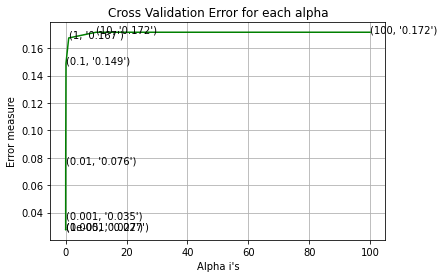

For values of best alpha =  0.0001 The train log loss is: 0.01400212337017917
For values of best alpha =  0.0001 The cross validation log loss is: 0.027401511659601474
For values of best alpha =  0.0001 The test log loss is: 0.022887286069705474


In [ ]:
alpha = [10 ** x for x in range(-5, 3)]
cv_log_error_array = []
for i in alpha:
    print("for C =", i)
#     clf = SVC(C=i,kernel='linear',probability=True, class_weight='balanced')
    clf = SGDClassifier( alpha=i, penalty='l2', loss='hinge', random_state=42)
    clf.fit(X_train_onehot, train_y)
    sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
    sig_clf.fit(X_train_onehot, train_y)
    sig_clf_probs = sig_clf.predict_proba(X_cv_onehot)
    cv_log_error_array.append(log_loss(cv_y, sig_clf_probs, labels=clf.classes_, eps=1e-15))
    print("Log Loss :",log_loss(cv_y, sig_clf_probs)) 

fig, ax = plt.subplots()
ax.plot(alpha, cv_log_error_array,c='g')
for i, txt in enumerate(np.round(cv_log_error_array,3)):
    ax.annotate((alpha[i],str(txt)), (alpha[i],cv_log_error_array[i]))
plt.grid()
plt.title("Cross Validation Error for each alpha")
plt.xlabel("Alpha i's")
plt.ylabel("Error measure")
plt.show()


best_alpha = np.argmin(cv_log_error_array)
# clf = SVC(C=i,kernel='linear',probability=True, class_weight='balanced')
clf = SGDClassifier(alpha=alpha[best_alpha], penalty='l2', loss='hinge', random_state=42)
clf.fit(X_train_onehot, train_y)
sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
sig_clf.fit(X_train_onehot, train_y)

predict_y = sig_clf.predict_proba(X_train_onehot)
print('For values of best alpha = ', alpha[best_alpha], "The train log loss is:",log_loss(y_train, predict_y, labels=clf.classes_, eps=1e-15))
predict_y = sig_clf.predict_proba(X_cv_onehot)
print('For values of best alpha = ', alpha[best_alpha], "The cross validation log loss is:",log_loss(y_cv, predict_y, labels=clf.classes_, eps=1e-15))
predict_y = sig_clf.predict_proba(X_test_onehot)
print('For values of best alpha = ', alpha[best_alpha], "The test log loss is:",log_loss(y_test, predict_y, labels=clf.classes_, eps=1e-15))

Log loss : 0.022887286069705474
Number of mis-classified points : 0.006335797254487857
-------------------- Confusion matrix --------------------


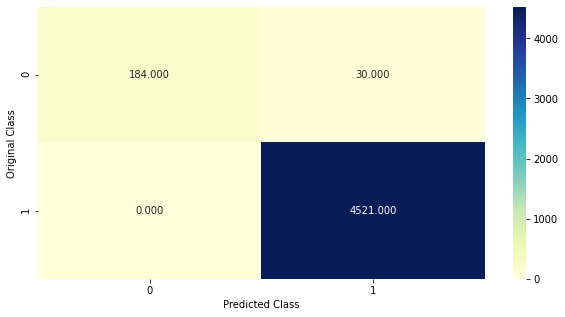

-------------------- Precision matrix (Columm Sum=1) --------------------


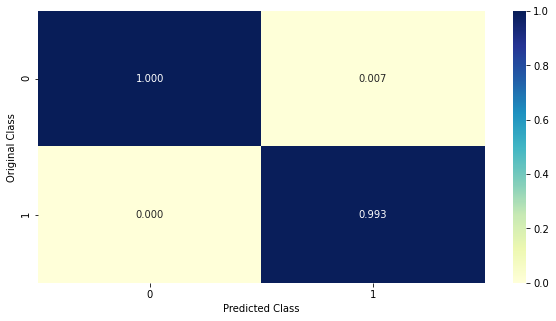

-------------------- Recall matrix (Row sum=1) --------------------


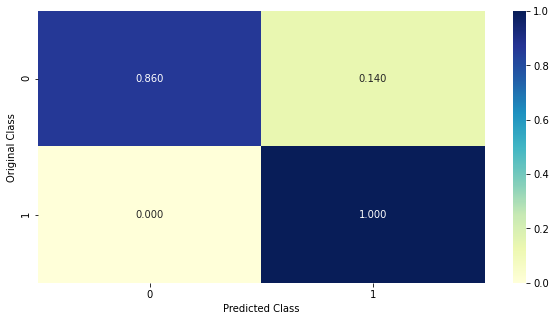

In [ ]:
clf = SGDClassifier(alpha=alpha[best_alpha], penalty='l2', loss='hinge', random_state=42)
predict_and_plot_confusion_matrix(X_train_onehot, train_y,X_test_onehot, test_y, clf)

There a more number of FN values for this, again this model not did good work as compared to K-NN

<h2> Random Forest(one hot encoding)</h2>

**Hyperparam tuning**

In [ ]:
alpha = [100,200,500,1000,2000]
max_depth = [5, 10]
cv_log_error_array = []
for i in alpha:
    for j in max_depth:
        print("for n_estimators =", i,"and max depth = ", j)
        clf = RandomForestClassifier(n_estimators=i, criterion='gini', max_depth=j, random_state=42, n_jobs=-1)
        clf.fit(X_train_onehot, train_y)
        sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
        sig_clf.fit(X_train_onehot, train_y)
        sig_clf_probs = sig_clf.predict_proba(X_cv_onehot)
        cv_log_error_array.append(log_loss(cv_y, sig_clf_probs, labels=clf.classes_, eps=1e-15))
        print("Log Loss :",log_loss(cv_y, sig_clf_probs)) 

'''fig, ax = plt.subplots()
features = np.dot(np.array(alpha)[:,None],np.array(max_depth)[None]).ravel()
ax.plot(features, cv_log_error_array,c='g')
for i, txt in enumerate(np.round(cv_log_error_array,3)):
    ax.annotate((alpha[int(i/2)],max_depth[int(i%2)],str(txt)), (features[i],cv_log_error_array[i]))
plt.grid()
plt.title("Cross Validation Error for each alpha")
plt.xlabel("Alpha i's")
plt.ylabel("Error measure")
plt.show()
'''

best_alpha = np.argmin(cv_log_error_array)
clf = RandomForestClassifier(n_estimators=alpha[int(best_alpha/2)], criterion='gini', max_depth=max_depth[int(best_alpha%2)], random_state=42, n_jobs=-1)
clf.fit(X_train_onehot, train_y)
sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
sig_clf.fit(X_train_onehot, train_y)

predict_y = sig_clf.predict_proba(X_train_onehot)
print('For values of best estimator = ', alpha[int(best_alpha/2)], "The train log loss is:",log_loss(y_train, predict_y, labels=clf.classes_, eps=1e-15))
predict_y = sig_clf.predict_proba(X_cv_onehot)
print('For values of best estimator = ', alpha[int(best_alpha/2)], "The cross validation log loss is:",log_loss(y_cv, predict_y, labels=clf.classes_, eps=1e-15))
predict_y = sig_clf.predict_proba(X_test_onehot)
print('For values of best estimator = ', alpha[int(best_alpha/2)], "The test log loss is:",log_loss(y_test, predict_y, labels=clf.classes_, eps=1e-15))

for n_estimators = 100 and max depth =  5
Log Loss : 0.03962347442184224
for n_estimators = 100 and max depth =  10
Log Loss : 0.037295595327528644
for n_estimators = 200 and max depth =  5
Log Loss : 0.03805271241597868
for n_estimators = 200 and max depth =  10
Log Loss : 0.0361032473374034
for n_estimators = 500 and max depth =  5
Log Loss : 0.0383034441808887
for n_estimators = 500 and max depth =  10
Log Loss : 0.036596299170963444
for n_estimators = 1000 and max depth =  5
Log Loss : 0.039011637684725056
for n_estimators = 1000 and max depth =  10
Log Loss : 0.03686764910793298
for n_estimators = 2000 and max depth =  5
Log Loss : 0.0389239963936442
for n_estimators = 2000 and max depth =  10
Log Loss : 0.03668114586652348
For values of best estimator =  200 The train log loss is: 0.021130530001026264
For values of best estimator =  200 The cross validation log loss is: 0.03610324733740343
For values of best estimator =  200 The test log loss is: 0.032742960357232426


Log loss : 0.03274296035723241
Number of mis-classified points : 0.007391763463569166
-------------------- Confusion matrix --------------------


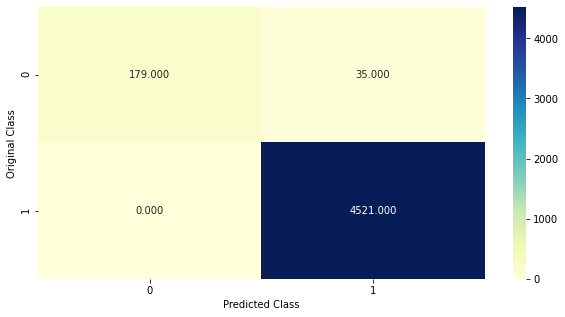

-------------------- Precision matrix (Columm Sum=1) --------------------


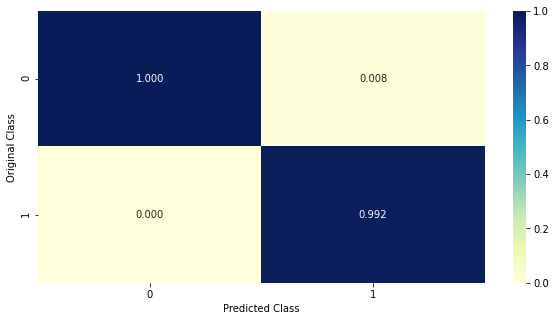

-------------------- Recall matrix (Row sum=1) --------------------


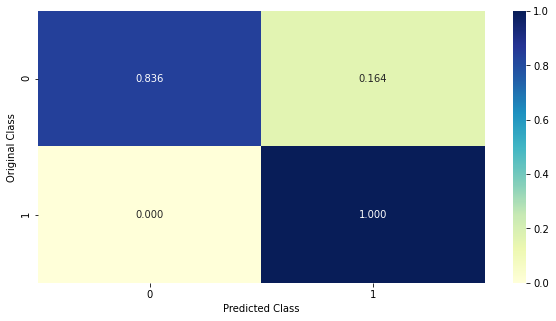

In [ ]:
clf = RandomForestClassifier(n_estimators=alpha[int(best_alpha/2)], criterion='gini', max_depth=max_depth[int(best_alpha%2)], random_state=42, n_jobs=-1)
predict_and_plot_confusion_matrix(X_train_onehot, train_y, X_test_onehot, test_y, clf)

We do see missclassified points, precision is fine, but recall is a concern using this model....

<h2> Random Forest(response encoding) </h2>

**hyperparam tuning**

In [ ]:
alpha = [10,50,100,200,500,1000]
max_depth = [2,3,5,10]
cv_log_error_array = []
for i in alpha:
    for j in max_depth:
        print("for n_estimators =", i,"and max depth = ", j)
        clf = RandomForestClassifier(n_estimators=i, criterion='gini', max_depth=j, random_state=42, n_jobs=-1)
        clf.fit(X_train_response, train_y)
        sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
        sig_clf.fit(X_train_response, train_y)
        sig_clf_probs = sig_clf.predict_proba(X_cv_response)
        cv_log_error_array.append(log_loss(cv_y, sig_clf_probs, labels=clf.classes_, eps=1e-15))
        print("Log Loss :",log_loss(cv_y, sig_clf_probs)) 
'''
fig, ax = plt.subplots()
features = np.dot(np.array(alpha)[:,None],np.array(max_depth)[None]).ravel()
ax.plot(features, cv_log_error_array,c='g')
for i, txt in enumerate(np.round(cv_log_error_array,3)):
    ax.annotate((alpha[int(i/4)],max_depth[int(i%4)],str(txt)), (features[i],cv_log_error_array[i]))
plt.grid()
plt.title("Cross Validation Error for each alpha")
plt.xlabel("Alpha i's")
plt.ylabel("Error measure")
plt.show()
'''

best_alpha = np.argmin(cv_log_error_array)
clf = RandomForestClassifier(n_estimators=alpha[int(best_alpha/4)], criterion='gini', max_depth=max_depth[int(best_alpha%4)], random_state=42, n_jobs=-1)
clf.fit(X_train_response, train_y)
sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
sig_clf.fit(X_train_response, train_y)

predict_y = sig_clf.predict_proba(X_train_response)
print('For values of best alpha = ', alpha[int(best_alpha/4)], "The train log loss is:",log_loss(train_y, predict_y, labels=clf.classes_, eps=1e-15))
predict_y = sig_clf.predict_proba(X_cv_response)
print('For values of best alpha = ', alpha[int(best_alpha/4)], "The cross validation log loss is:",log_loss(cv_y, predict_y, labels=clf.classes_, eps=1e-15))
predict_y = sig_clf.predict_proba(X_test_response)
print('For values of best alpha = ', alpha[int(best_alpha/4)], "The test log loss is:",log_loss(test_y, predict_y, labels=clf.classes_, eps=1e-15))

for n_estimators = 10 and max depth =  2
Log Loss : 0.0017588256320853137
for n_estimators = 10 and max depth =  3
Log Loss : 0.002031700111506507
for n_estimators = 10 and max depth =  5
Log Loss : 0.0014205967484013512
for n_estimators = 10 and max depth =  10
Log Loss : 0.001895511606176898
for n_estimators = 50 and max depth =  2
Log Loss : 0.0016428439051935945
for n_estimators = 50 and max depth =  3
Log Loss : 0.0019504538331474297
for n_estimators = 50 and max depth =  5
Log Loss : 0.002765314173377889
for n_estimators = 50 and max depth =  10
Log Loss : 0.002951865774957266
for n_estimators = 100 and max depth =  2
Log Loss : 0.0026058635553709904
for n_estimators = 100 and max depth =  3
Log Loss : 0.003828672108628249
for n_estimators = 100 and max depth =  5
Log Loss : 0.0043812675023204165
for n_estimators = 100 and max depth =  10
Log Loss : 0.004566683588836826
for n_estimators = 200 and max depth =  2
Log Loss : 0.0020123859261263386
for n_estimators = 200 and max depth

Log loss : 0.001109735725018856
Number of mis-classified points : 0.0
-------------------- Confusion matrix --------------------


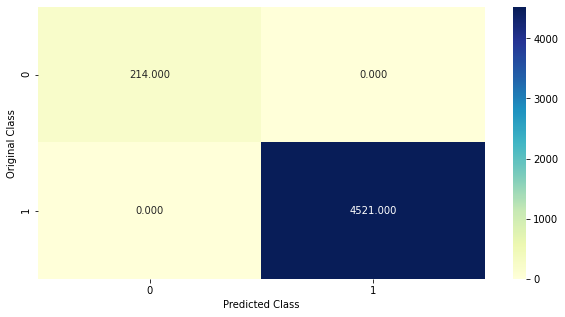

-------------------- Precision matrix (Columm Sum=1) --------------------


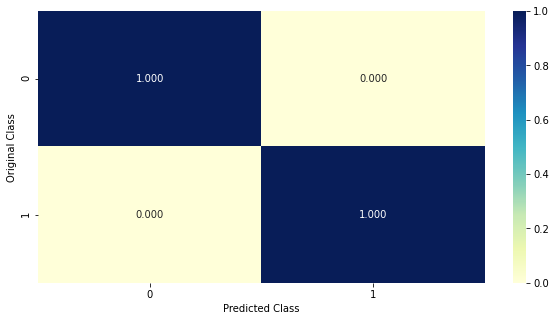

-------------------- Recall matrix (Row sum=1) --------------------


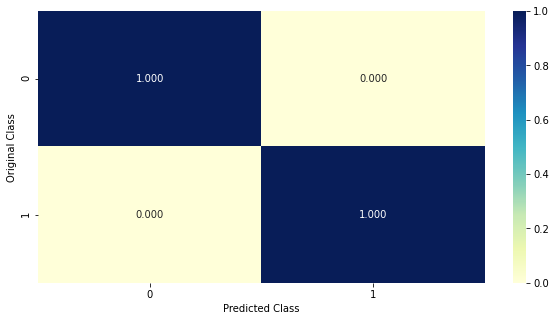

In [ ]:
clf = RandomForestClassifier(max_depth=max_depth[int(best_alpha%4)], n_estimators=alpha[int(best_alpha/4)], criterion='gini', max_features='auto',random_state=42)
predict_and_plot_confusion_matrix(X_train_response, train_y, X_test_response, test_y, clf)

This seems to be a perfect model, no missclassification point, model did well on 100% of test point, it will be interesting to see how these params will do when making predicitons on test set.....

#Conclusions

In [ ]:
from prettytable import PrettyTable
x = PrettyTable()
x.field_names = ["Model", "Train Log Loss", "CV Log Loss", "Test Log Loss"]

x.add_row(["KNN + response coding)", .0027, .0039, .0022])
x.add_row(["LR + one hot encoding + balancing)", .016, .031, .025])
x.add_row(["LR + one hot encoding + no balancing)", .012, .027, .021])
x.add_row(["Linear SVM + one hot encoding + balancing)", .020, .035, .030])
x.add_row(["Linear SVM + one hot encoding + no balancing)", .014, .027, .023])
x.add_row(["RF + one hot encoding)", .021, .036, .032])
x.add_row(["RF + response coding)", .00077, .0014, .0011])

print(x)

+-----------------------------------------------+----------------+-------------+---------------+
|                     Model                     | Train Log Loss | CV Log Loss | Test Log Loss |
+-----------------------------------------------+----------------+-------------+---------------+
|             KNN + response coding)            |     0.0027     |    0.0039   |     0.0022    |
|       LR + one hot encoding + balancing)      |     0.016      |    0.031    |     0.025     |
|     LR + one hot encoding + no balancing)     |     0.012      |    0.027    |     0.021     |
|   Linear SVM + one hot encoding + balancing)  |      0.02      |    0.035    |      0.03     |
| Linear SVM + one hot encoding + no balancing) |     0.014      |    0.027    |     0.023     |
|             RF + one hot encoding)            |     0.021      |    0.036    |     0.032     |
|             RF + response coding)             |    0.00077     |    0.0014   |     0.0011    |
+-----------------------------

From above table it seems KNN and RF did good job with response encoding, now, we will use our trained model to do prediction on test data, we will use all of our train data and then make a prediction on test data provided to us and will do submission after this....

#Predcitions on test file

In [ ]:
train_data.head()

,X_1,X_2,X_4,X_5,X_7,X_8,X_9,X_10,X_11,X_12,X_13,X_14,X_15,MULTIPLE_OFFENSE,dow,is_weekend
0,0,36,2,1,6,1,6,1,174,1.0,92,29,36,0,6,1
1,1,37,0,0,17,1,6,1,236,1.0,103,142,34,1,1,0
2,0,3,3,5,0,2,3,1,174,1.0,110,93,34,1,2,0
3,0,33,2,1,1,1,6,1,249,1.0,72,29,34,1,4,0
4,0,33,2,1,3,0,5,1,174,0.0,112,29,43,1,2,0


<h2> Loading test file </h2>

In [ ]:
test_data = pd.read_csv('/content/drive/My Drive/Novartis_Test/Test.csv')

In [ ]:
test_data.head()

,INCIDENT_ID,DATE,X_1,X_2,X_3,X_4,X_5,X_6,X_7,X_8,X_9,X_10,X_11,X_12,X_13,X_14,X_15
0,CR_195453,01-FEB-18,0,30,35,7,3,6,4,0,5,1,174,NaN,72,119,23
1,CR_103520,05-MAR-04,0,44,44,1,3,7,1,4,6,1,316,0.0,12,29,34
2,CR_196089,27-JAN-18,0,34,33,3,5,2,7,3,0,1,316,1.0,72,0,34
3,CR_112195,18-AUG-06,7,3,2,3,5,9,8,0,5,1,174,1.0,112,87,34
4,CR_149832,31-OCT-11,0,7,8,7,3,2,7,1,5,1,174,0.0,112,93,43


<h2> Preparing test data as per the train data </h2>

In [ ]:
#Creating 2 new features, dropping columns
test_data['DATE'] = pd.to_datetime(test_data['DATE'])
test_data['dow'] = test_data['DATE'].apply(lambda x: x.date().weekday())
test_data['is_weekend'] = test_data['DATE'].apply(lambda x: 1 if x.date().weekday() in (5, 6) else 0)
#Dropping DATE column
test_data = test_data.drop('DATE', axis = 1)
test_data = test_data.drop('INCIDENT_ID', axis = 1)
test_data = test_data.drop('X_3', axis =1)
test_data = test_data.drop('X_6', axis =1)

In [ ]:
test_data['X_1'] = test_data['X_1'].astype('str')
test_data['X_2'] = test_data['X_2'].astype('str')
test_data['X_4'] = test_data['X_4'].astype('str')
test_data['X_5'] = test_data['X_5'].astype('str')
test_data['X_7'] = test_data['X_7'].astype('str')
test_data['X_8'] = test_data['X_8'].astype('str')
test_data['X_9'] = test_data['X_9'].astype('str')
test_data['X_10'] = test_data['X_10'].astype('str')
test_data['X_11'] = test_data['X_11'].astype('str')
test_data['X_12'] = test_data['X_12'].astype('str')
test_data['X_13'] = test_data['X_13'].astype('str')
test_data['X_14'] = test_data['X_14'].astype('str')
test_data['X_15'] = test_data['X_15'].astype('str')
test_data['dow'] = test_data['dow'].astype('str')

In [ ]:
test_data.head()

,X_1,X_2,X_4,X_5,X_7,X_8,X_9,X_10,X_11,X_12,X_13,X_14,X_15,dow,is_weekend
0,0,30,7,3,4,0,5,1,174,nan,72,119,23,3,0
1,0,44,1,3,1,4,6,1,316,0.0,12,29,34,4,0
2,0,34,3,5,7,3,0,1,316,1.0,72,0,34,5,1
3,7,3,3,5,8,0,5,1,174,1.0,112,87,34,4,0
4,0,7,7,3,7,1,5,1,174,0.0,112,93,43,0,0


X_12 in test set also have null values, but that will be dealt on by response encoding fit function, so, we are using train data to create a vector of length 2 which will have probab of that level in the variable, for all the levels(categories) that are not part of train, will get a value of [0.5, 0.5] in test, this solves 2 problem, it makes our test unseen and avoids data leakage issue, also for categories whose information is not available in train, it gives them a value of equal probab, so for null values in test, will be getting a vector of 2 with equal chances of both the labels...

<h2> Encoding train and test data </h2>

In [ ]:
alpha = 1
fit_X1 = fit_function(alpha, 'X_1', train_data)
X1_train_re = transform_function(fit_X1, 'X_1',train_data)
X1_test_re = transform_function(fit_X1, 'X_1',test_data)

print(X1_train_re.shape, X1_test_re.shape)

(23674, 2) (15903, 2)


In [ ]:
fit_X2 = fit_function(alpha, 'X_2', train_data)
X2_train_re = transform_function(fit_X2, 'X_2',train_data)
X2_test_re = transform_function(fit_X2, 'X_2',test_data)

print(X2_train_re.shape, X2_test_re.shape)

(23674, 2) (15903, 2)


In [ ]:
fit_X4 = fit_function(alpha, 'X_4', train_data)
X4_train_re = transform_function(fit_X4, 'X_4',train_data)
X4_test_re = transform_function(fit_X4, 'X_4',test_data)

print(X4_train_re.shape, X4_test_re.shape)

(23674, 2) (15903, 2)


In [ ]:
fit_X5 = fit_function(alpha, 'X_5', train_data)
X5_train_re = transform_function(fit_X5, 'X_5',train_data)
X5_test_re = transform_function(fit_X5, 'X_5',test_data)

print(X5_train_re.shape, X5_test_re.shape)

(23674, 2) (15903, 2)


In [ ]:
fit_X7 = fit_function(alpha, 'X_7', train_data)
X7_train_re = transform_function(fit_X7, 'X_7',train_data)
X7_test_re = transform_function(fit_X7, 'X_7',test_data)

print(X7_train_re.shape, X7_test_re.shape)

(23674, 2) (15903, 2)


In [ ]:
fit_X8 = fit_function(alpha, 'X_8', train_data)
X8_train_re = transform_function(fit_X8, 'X_8',train_data)
X8_test_re = transform_function(fit_X8, 'X_8',test_data)

print(X8_train_re.shape, X8_test_re.shape)

(23674, 2) (15903, 2)


In [ ]:
fit_X9 = fit_function(alpha, 'X_9', train_data)
X9_train_re = transform_function(fit_X9, 'X_9',train_data)
X9_test_re = transform_function(fit_X9, 'X_9',test_data)

print(X9_train_re.shape, X9_test_re.shape)

(23674, 2) (15903, 2)


In [ ]:
fit_X10 = fit_function(alpha, 'X_10', train_data)
X10_train_re = transform_function(fit_X10, 'X_10',train_data)
X10_test_re = transform_function(fit_X10, 'X_10',test_data)

print(X10_train_re.shape, X10_test_re.shape)

(23674, 2) (15903, 2)


In [ ]:
fit_X11 = fit_function(alpha, 'X_11', train_data)
X11_train_re = transform_function(fit_X11, 'X_11',train_data)
X11_test_re = transform_function(fit_X11, 'X_11',test_data)

print(X11_train_re.shape, X11_test_re.shape)

(23674, 2) (15903, 2)


In [ ]:
fit_X12 = fit_function(alpha, 'X_12', train_data)
X12_train_re = transform_function(fit_X12, 'X_12',train_data)
X12_test_re = transform_function(fit_X12, 'X_12',test_data)

print(X12_train_re.shape, X12_test_re.shape)

(23674, 2) (15903, 2)


In [ ]:
fit_X13 = fit_function(alpha, 'X_13', train_data)
X13_train_re = transform_function(fit_X13, 'X_13',train_data)
X13_test_re = transform_function(fit_X13, 'X_13',test_data)

print(X13_train_re.shape, X13_test_re.shape)

(23674, 2) (15903, 2)


In [ ]:
fit_X14 = fit_function(alpha, 'X_14', train_data)
X14_train_re = transform_function(fit_X14, 'X_14',train_data)
X14_test_re = transform_function(fit_X14, 'X_14',test_data)

print(X14_train_re.shape, X14_test_re.shape)

(23674, 2) (15903, 2)


In [ ]:
fit_X15 = fit_function(alpha, 'X_15', train_data)
X15_train_re = transform_function(fit_X15, 'X_15',train_data)
X15_test_re = transform_function(fit_X15, 'X_15',test_data)

print(X15_train_re.shape, X15_test_re.shape)

(23674, 2) (15903, 2)


In [ ]:
fit_dow = fit_function(alpha, 'dow', train_data)
dow_train_re = transform_function(fit_dow, 'dow',train_data)
dow_test_re = transform_function(fit_dow, 'dow',test_data)

print(dow_train_re.shape, dow_test_re.shape)

(23674, 2) (15903, 2)


<h2> Stacking the data </h2>

In [ ]:
from numpy import hstack
train_stack = hstack((X1_train_re, X2_train_re, X4_train_re, X5_train_re, X7_train_re, X8_train_re, X9_train_re, X10_train_re, X11_train_re, X12_train_re, X13_train_re, X14_train_re, X15_train_re, dow_train_re))
test_stack = hstack((X1_test_re, X2_test_re, X4_test_re, X5_test_re, X7_test_re, X8_test_re, X9_test_re, X10_test_re, X11_test_re, X12_test_re, X13_test_re, X14_test_re, X15_test_re, dow_test_re))

In [ ]:
print(train_stack.shape, test_stack.shape)

(23674, 28) (15903, 28)


In [ ]:
y_train = np.array(list(train_data['MULTIPLE_OFFENSE']))

In [ ]:
y_train.shape

(23674,)

<h2> USing k-NN to make predictions on test data </h2>

In [ ]:
clf = KNeighborsClassifier(n_neighbors=k[best_k])
clf.fit(train_stack, y_train)

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
                     metric_params=None, n_jobs=None, n_neighbors=11, p=2,
                     weights='uniform')

In [ ]:
predict_y = clf.predict(test_stack)

<h2> making submission file </h2>

In [ ]:
submission_test = pd.read_csv('/content/drive/My Drive/Novartis_Test/Test.csv')

In [ ]:
submission_knn = submission_test
submission_knn['MULTIPLE_OFFENSE'] = predict_y
submission_knn = submission_knn[['INCIDENT_ID', 'MULTIPLE_OFFENSE']]
submission_knn['MULTIPLE_OFFENSE'].value_counts(normalize = True)

1    0.953908
0    0.046092
Name: MULTIPLE_OFFENSE, dtype: float64

In [ ]:
submission_knn.to_csv('/content/drive/My Drive/Novartis_Test/submission_knn.csv', index = False)

**This submission generated a score of 99.91**

<h2> Using Random Forest for predcition </h2>

In [ ]:
clf = RandomForestClassifier(n_estimators=alpha[int(best_alpha/4)], criterion='gini', max_depth=max_depth[int(best_alpha%4)], random_state=42, n_jobs=-1)
clf.fit(train_stack, y_train)
predict_y = clf.predict(test_stack)

<h2> Making submission file </h2>

In [ ]:
submission_rf = submission_test
submission_rf['MULTIPLE_OFFENSE'] = predict_y
submission_rf = submission_rf[['INCIDENT_ID', 'MULTIPLE_OFFENSE']]
submission_rf['MULTIPLE_OFFENSE'].value_counts(normalize = True)

1    0.954537
0    0.045463
Name: MULTIPLE_OFFENSE, dtype: float64

In [ ]:
submission_rf.to_csv('/content/drive/My Drive/Novartis_Test/submission_rf.csv', index = False)

**This submission generated a score of 99.72**

K-NN and RF with response encoded vectors gave good results on test set.....